In [4]:
import shap
import json
import kaggle
import random
import optuna
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from datetime import datetime
from sklearn.metrics import ndcg_score, r2_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.width', 2000)
random.seed(128)
shap.initjs()

---

# 0. Data download

In [3]:
!kaggle competitions download -c airbnb-recruiting-new-user-bookings
!unzip airbnb-recruiting-new-user-bookings.zip
!dir

100%|██████████████████████████████████████| 64.7M/64.7M [00:59<00:00, 1.46MB/s]
100%|██████████████████████████████████████| 64.7M/64.7M [00:59<00:00, 1.14MB/s]
Archive:  airbnb-recruiting-new-user-bookings.zip
  inflating: age_gender_bkts.csv.zip  
  inflating: countries.csv.zip       
  inflating: sample_submission_NDF.csv.zip  
  inflating: sessions.csv.zip        
  inflating: test_users.csv.zip      
  inflating: train_users_2.csv.zip   
age_gender_bkts.csv			 sample_submission_NDF.csv
age_gender_bkts.csv.zip			 sample_submission_NDF.csv.zip
Airbnb_New_User_Bookings.ipynb		 sessions.csv
Airbnb_New_User_Bookings_v4.ipynb	 sessions.csv.zip
airbnb-recruiting-new-user-bookings.zip  test_users.csv
catboost_info				 test_users.csv.zip
countries.csv				 train_users_2.csv
countries.csv.zip			 train_users_2.csv.zip
features.csv				 Архив
prediction.csv


In [4]:
!rm -f airbnb-recruiting-new-user-bookings.zip
!unzip '*.zip'
!dir

Archive:  train_users_2.csv.zip
replace train_users_2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
age_gender_bkts.csv		   sample_submission_NDF.csv
age_gender_bkts.csv.zip		   sample_submission_NDF.csv.zip
Airbnb_New_User_Bookings.ipynb	   sessions.csv
Airbnb_New_User_Bookings_v4.ipynb  sessions.csv.zip
catboost_info			   test_users.csv
countries.csv			   test_users.csv.zip
countries.csv.zip		   train_users_2.csv
features.csv			   train_users_2.csv.zip
prediction.csv			   Архив


In [5]:
!rm -f *.zip
!dir

age_gender_bkts.csv		   countries.csv	      sessions.csv
Airbnb_New_User_Bookings.ipynb	   features.csv		      test_users.csv
Airbnb_New_User_Bookings_v4.ipynb  prediction.csv	      train_users_2.csv
catboost_info			   sample_submission_NDF.csv  Архив


---

# 1. Exploration Data Analysis

### File descriptions

*    train_users.csv - the training set of users
*    test_users.csv - the test set of users
     *   id: user id
     *   date_account_created: the date of account creation
     *   timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
     *   date_first_booking: date of first booking
     *   gender
     *   age
     *   signup_method
     *   signup_flow: the page a user came to signup up from
     *   language: international language preference
     *   affiliate_channel: what kind of paid marketing
     *   affiliate_provider: where the marketing is e.g. google, craigslist, other
     *   first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
     *   signup_app
     *   first_device_type
     *   first_browser
     *   country_destination: this is the target variable you are to predict
*    sessions.csv - web sessions log for users
     *   user_id: to be joined with the column 'id' in users table
     *   action
     *   action_type
     *   action_detail
     *   device_type
     *   secs_elapsed
*    countries.csv - summary statistics of destination countries in this dataset and their locations
*    age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination
*    sample_submission.csv - correct format for submitting your predictions


## 1.1 View the data

In [38]:
age_gender_bkts = pd.read_csv('age_gender_bkts.csv')
countries = pd.read_csv('countries.csv')
sessions = pd.read_csv('sessions.csv')
train_users = pd.read_csv('train_users_2.csv')
test_users = pd.read_csv('test_users.csv')

In [4]:
def ds_quick_view(df: pd.DataFrame) -> None:
    """
    Function prints main parameters of data
    :df:     Input dataframe with data
    :return: Returns none, only prints statistics
    """
    print(df.head())
    print(80 * '*')
    print(df.info(show_counts=True))
    print(80 * '*')
    print(df.describe(include='all'))

In [8]:
ds_quick_view(age_gender_bkts)

  age_bucket country_destination gender  population_in_thousands    year
0       100+                  AU   male                      1.0  2015.0
1      95-99                  AU   male                      9.0  2015.0
2      90-94                  AU   male                     47.0  2015.0
3      85-89                  AU   male                    118.0  2015.0
4      80-84                  AU   male                    199.0  2015.0
********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64

In [9]:
age_gender_bkts['age_bucket'].value_counts()

100+     20
45-49    20
5-9      20
10-14    20
15-19    20
20-24    20
25-29    20
30-34    20
35-39    20
40-44    20
50-54    20
95-99    20
55-59    20
60-64    20
65-69    20
70-74    20
75-79    20
80-84    20
85-89    20
90-94    20
0-4      20
Name: age_bucket, dtype: int64

### Short Sum (age_gender_bkts):
* No missings;
* Contains target column with 10 classes;
* Gender has 2 categories with 50/50;
* 20 values in each age bucket.

In [10]:
ds_quick_view(countries)

  country_destination  lat_destination  lng_destination  distance_km  destination_km2 destination_language   language_levenshtein_distance
0                  AU       -26.853388       133.275160   15297.7440        7741220.0                   eng                           0.00
1                  CA        62.393303       -96.818146    2828.1333        9984670.0                   eng                           0.00
2                  DE        51.165707        10.452764    7879.5680         357022.0                   deu                          72.61
3                  ES        39.896027        -2.487694    7730.7240         505370.0                   spa                          92.25
4                  FR        46.232193         2.209667    7682.9450         643801.0                   fra                          92.06
********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (to

In [11]:
countries['country_destination'].unique()

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US'],
      dtype=object)

### Short Sum (countries):
* No empty values
* Doesn't contain 'NDF' and 'other' labels

In [12]:
ds_quick_view(sessions)

      user_id          action action_type        action_detail      device_type  secs_elapsed
0  d1mm9tcy42          lookup         NaN                  NaN  Windows Desktop         319.0
1  d1mm9tcy42  search_results       click  view_search_results  Windows Desktop       67753.0
2  d1mm9tcy42          lookup         NaN                  NaN  Windows Desktop         301.0
3  d1mm9tcy42  search_results       click  view_search_results  Windows Desktop       22141.0
4  d1mm9tcy42          lookup         NaN                  NaN  Windows Desktop         435.0
********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   user_id        10533241 non-null  object 
 1   action         10488111 non-null  object 
 2   action_type    9441533 non-null   object 
 3   a

### Short Sum (sessions):
* There are NaN values in actions (assumed no actions, e.g. '0' value)
* Contains users info that could be converted into statistical features

In [13]:
# very wide table looks better in pandas api
train_users.head(10)

id date_account_created  timestamp_first_active date_first_booking     gender   age signup_method  signup_flow language affiliate_channel affiliate_provider first_affiliate_tracked signup_app first_device_type first_browser country_destination
0  gxn3p5htnn           2010-06-28          20090319043255                NaN  -unknown-   NaN      facebook            0       en            direct             direct               untracked        Web       Mac Desktop        Chrome                 NDF
1  820tgsjxq7           2011-05-25          20090523174809                NaN       MALE  38.0      facebook            0       en               seo             google               untracked        Web       Mac Desktop        Chrome                 NDF
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02     FEMALE  56.0         basic            3       en            direct             direct               untracked        Web   Windows Desktop            IE                  US
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08     FEMALE  42.0      facebook            0       en            direct             direct               untracked        Web       Mac Desktop       Firefox               other
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18  -unknown-  41.0         basic            0       en            direct             direct               untracked        Web       Mac Desktop        Chrome                  US
5  osr2jwljor           2010-01-01          20100101215619         2010-01-02  -unknown-   NaN         basic            0       en             other              other                     omg        Web       Mac Desktop        Chrome                  US
6  lsw9q7uk0j           2010-01-02          20100102012558         2010-01-05     FEMALE  46.0         basic            0       en             other         craigslist               untracked        Web       Mac Desktop        Safari                  US
7  0d01nltbrs           2010-01-03          20100103191905         2010-01-13     FEMALE  47.0         basic            0       en            direct             direct                     omg        Web       Mac Desktop        Safari                  US
8  a1vcnhxeij           2010-01-04          20100104004211         2010-07-29     FEMALE  50.0         basic            0       en             other         craigslist               untracked        Web       Mac Desktop        Safari                  US
9  6uh8zyj2gn           2010-01-04          20100104023758         2010-01-04  -unknown-  46.0         basic            0       en             other         craigslist                     omg        Web       Mac Desktop       Firefox                  US

In [14]:
train_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [15]:
test_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

In [16]:
train_users.describe(include='all')

id date_account_created  timestamp_first_active date_first_booking     gender            age signup_method    signup_flow language affiliate_channel affiliate_provider first_affiliate_tracked signup_app first_device_type first_browser country_destination
count       213451               213451            2.134510e+05              88908     213451  125461.000000        213451  213451.000000   213451            213451             213451                  207386     213451            213451        213451              213451
unique      213451                 1634                     NaN               1976          4            NaN             3            NaN       25                 8                 18                       7          4                 9            52                  12
top     gxn3p5htnn           2014-05-13                     NaN         2014-05-22  -unknown-            NaN         basic            NaN       en            direct             direct               untracked        Web       Mac Desktop        Chrome                 NDF
freq             1                  674                     NaN                248      95688            NaN        152897            NaN   206314            137727             137426                  109232     182717             89600         63845              124543
mean           NaN                  NaN            2.013085e+13                NaN        NaN      49.668335           NaN       3.267387      NaN               NaN                NaN                     NaN        NaN               NaN           NaN                 NaN
std            NaN                  NaN            9.253717e+09                NaN        NaN     155.666612           NaN       7.637707      NaN               NaN                NaN                     NaN        NaN               NaN           NaN                 NaN
min            NaN                  NaN            2.009032e+13                NaN        NaN       1.000000           NaN       0.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN                 NaN
25%            NaN                  NaN            2.012123e+13                NaN        NaN      28.000000           NaN       0.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN                 NaN
50%            NaN                  NaN            2.013091e+13                NaN        NaN      34.000000           NaN       0.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN                 NaN
75%            NaN                  NaN            2.014031e+13                NaN        NaN      43.000000           NaN       0.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN                 NaN
max            NaN                  NaN            2.014063e+13                NaN        NaN    2014.000000           NaN      25.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN                 NaN

In [17]:
test_users.describe(include='all')

id date_account_created  timestamp_first_active  date_first_booking     gender           age signup_method   signup_flow language affiliate_channel affiliate_provider first_affiliate_tracked signup_app first_device_type first_browser
count        62096                62096            6.209600e+04                 0.0      62096  33220.000000         62096  62096.000000    62096             62096              62096                   62076      62096             62096         62096
unique       62096                   92                     NaN                 NaN          4           NaN             4           NaN       24                 7                 17                       7          4                 9            31
top     5uwns89zht           2014-07-23                     NaN                 NaN  -unknown-           NaN         basic           NaN       en            direct             direct               untracked        Web            iPhone     -unknown-
freq             1                 1105                     NaN                 NaN      33792           NaN         45325           NaN    59224             43844              43844                   33949      37201             19055         17128
mean           NaN                  NaN            2.014081e+13                 NaN        NaN     37.616677           NaN      7.813885      NaN               NaN                NaN                     NaN        NaN               NaN           NaN
std            NaN                  NaN            8.024585e+07                 NaN        NaN     74.440647           NaN     11.254291      NaN               NaN                NaN                     NaN        NaN               NaN           NaN
min            NaN                  NaN            2.014070e+13                 NaN        NaN      1.000000           NaN      0.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN
25%            NaN                  NaN            2.014072e+13                 NaN        NaN     26.000000           NaN      0.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN
50%            NaN                  NaN            2.014081e+13                 NaN        NaN     31.000000           NaN      0.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN
75%            NaN                  NaN            2.014091e+13                 NaN        NaN     40.000000           NaN     23.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN
max            NaN                  NaN            2.014093e+13                 NaN        NaN   2002.000000           NaN     25.000000      NaN               NaN                NaN                     NaN        NaN               NaN           NaN

In [20]:
train_users['country_destination'].value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [18]:
train_users['signup_method'].value_counts(), test_users['signup_method'].value_counts()

(basic       152897
 facebook     60008
 google         546
 Name: signup_method, dtype: int64,
 basic       45325
 facebook    14856
 google       1892
 weibo          23
 Name: signup_method, dtype: int64)

In [19]:
train_users['gender'].value_counts(), test_users['gender'].value_counts()

(-unknown-    95688
 FEMALE       63041
 MALE         54440
 OTHER          282
 Name: gender, dtype: int64,
 -unknown-    33792
 FEMALE       14483
 MALE         13769
 OTHER           52
 Name: gender, dtype: int64)

### Short Sum (datasets):
* There are unknowns in some cols;
* Dataset predominantly contains categorical features;
* Date_first_booking is obviousely totally empty for test (suppose to omit it); 
* Signup_method in test dataset has 4 unique values as train dataset has only 3, but the amount of new category is low;
* Ages 2000+ could be wrongly filled by birth year, so just subtract it from 2015 (dataset year according to description and age_gender_bkts['year']);
* The target has a high disbalance in classes...

## 1.2 Correct abnormal values and graphic analysis

### 1.2.1 TYPE CORRECTIONS

In [39]:
#!!! CHANGING DATA !!!
countries['destination_language '] = countries['destination_language '].apply(lambda x: x[:2])

train_users['gender'] = train_users['gender'].apply(lambda x: x.lower())
train_users.loc[train_users['language'] == 'ca', 'language'] = 'en'
train_users['timestamp_first_active'] = pd.to_datetime(train_users['timestamp_first_active'], format='%Y%m%d%H%M%S')
train_users['date_account_created'] = train_users['date_account_created'].astype('datetime64[ns]')
train_users['date_first_booking'] = train_users['date_first_booking'].astype('datetime64[ns]')

### 1.2.2 AGE

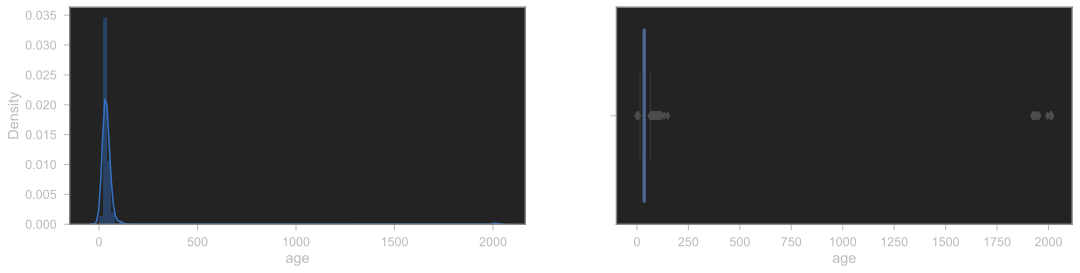

In [60]:
plt.figure(figsize=(18, 4))

plt.subplot(121)
sns.distplot(train_users['age'], bins=100)

plt.subplot(122)
sns.boxplot(train_users['age'], linewidth=0.5)

plt.show()

![title](img/age_stats.png)

In [40]:
#!!! CHANGING DATA !!!
# Replace incorrected AGE to '2015 - age'. Ages < 15 and > 115 (more 115 is really rare age) looks like outliers...
train_users.loc[train_users['age'] > 1900, 'age'] = 2015 - train_users['age']
train_users.loc[(train_users['age'] > 100) | (train_users['age'] < 15), 'age'] = np.nan

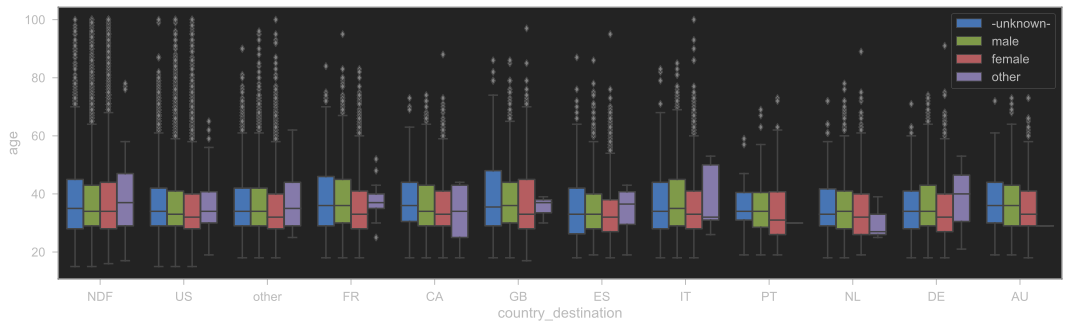

In [62]:
plt.figure(figsize=(18, 5))
sns.boxplot(x=train_users['country_destination'], 
            y=train_users['age'], 
            hue=train_users['gender'],
            flierprops=dict(markerfacecolor="#808080"),
           )
plt.legend()
plt.show()

![title](img/age_gender_distr.png)

In [41]:
# !!! CHANGING DATA !!!
# Add some buckets according to age_gender_bkts
train_users['age_group'] = np.nan
train_users.loc[train_users['age'] < 4, 'age_group'] = '0-4'
train_users.loc[(train_users['age'] >= 5) & (train_users['age'] < 9), 'age_group'] = '5-9'
train_users.loc[(train_users['age'] >= 10) & (train_users['age'] < 14), 'age_group'] = '10-14'
train_users.loc[(train_users['age'] >= 15) & (train_users['age'] < 19), 'age_group'] = '15-19'
train_users.loc[(train_users['age'] >= 20) & (train_users['age'] < 24), 'age_group'] = '20-24'
train_users.loc[(train_users['age'] >= 25) & (train_users['age'] < 29), 'age_group'] = '25-29'
train_users.loc[(train_users['age'] >= 30) & (train_users['age'] < 34), 'age_group'] = '30-34'
train_users.loc[(train_users['age'] >= 35) & (train_users['age'] < 39), 'age_group'] = '35-39'
train_users.loc[(train_users['age'] >= 40) & (train_users['age'] < 44), 'age_group'] = '40-44'
train_users.loc[(train_users['age'] >= 45) & (train_users['age'] < 49), 'age_group'] = '45-49'
train_users.loc[(train_users['age'] >= 50) & (train_users['age'] < 54), 'age_group'] = '50-54'
train_users.loc[(train_users['age'] >= 55) & (train_users['age'] < 59), 'age_group'] = '55-59'
train_users.loc[(train_users['age'] >= 60) & (train_users['age'] < 64), 'age_group'] = '60-64'
train_users.loc[(train_users['age'] >= 65) & (train_users['age'] < 69), 'age_group'] = '65-69'
train_users.loc[(train_users['age'] >= 70) & (train_users['age'] < 74), 'age_group'] = '70-74'
train_users.loc[(train_users['age'] >= 75) & (train_users['age'] < 79), 'age_group'] = '75-79'
train_users.loc[(train_users['age'] >= 80) & (train_users['age'] < 84), 'age_group'] = '80-84'
train_users.loc[(train_users['age'] >= 85) & (train_users['age'] < 89), 'age_group'] = '85-89'
train_users.loc[(train_users['age'] >= 90) & (train_users['age'] < 94), 'age_group'] = '90-94'
train_users.loc[(train_users['age'] >= 95) & (train_users['age'] < 99), 'age_group'] = '95-99'
train_users.loc[train_users['age'] >= 100, 'age_group'] = '100+'

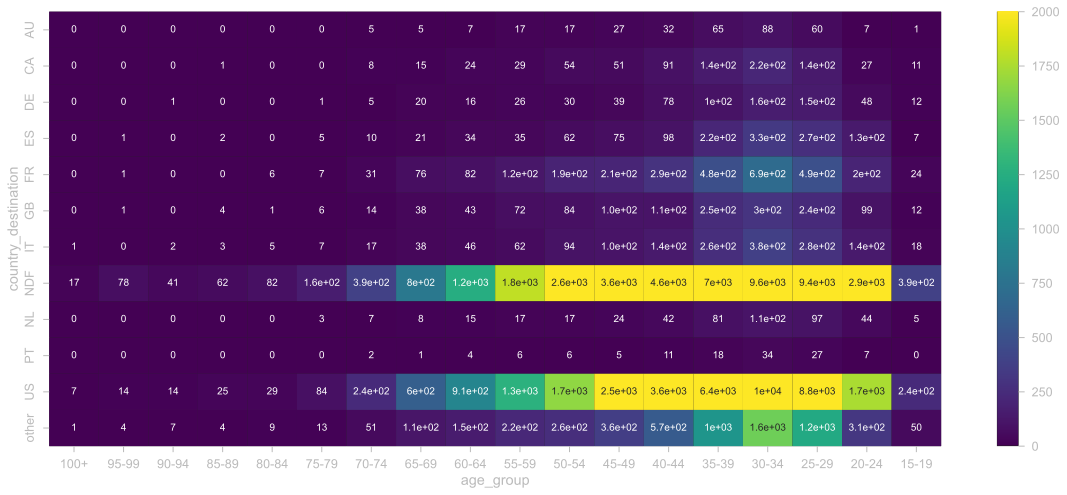

In [64]:
# Age of current users (amount) - target
plt.figure(figsize=(20, 8))
sns.heatmap(train_users.pivot_table(columns='age_group', index='country_destination', values='age', aggfunc='count').fillna(0)[age_gender_bkts['age_bucket'].unique()[:-3]],
            vmin=0, vmax=2000, center=1000, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/age_users-target.png)

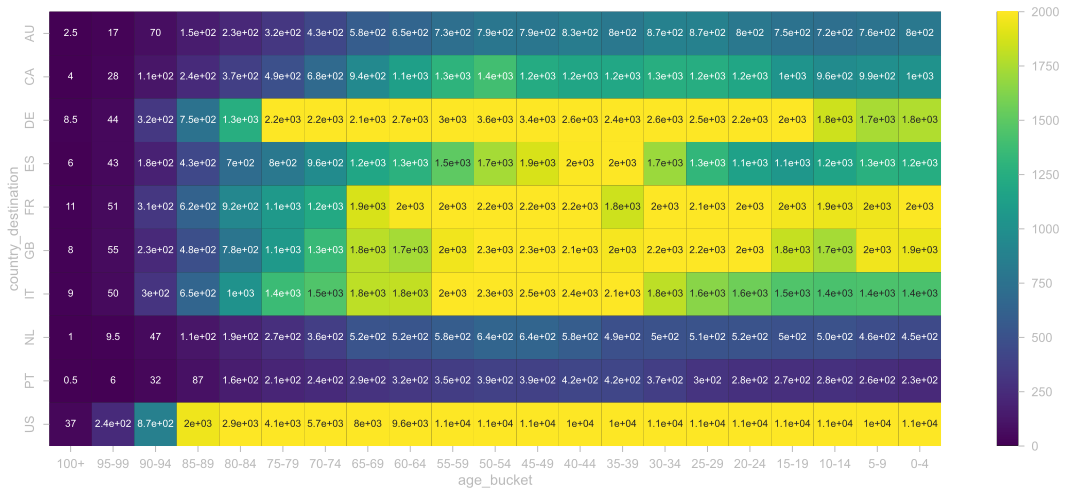

In [65]:
# Age of population (amount) - target
plt.figure(figsize=(20, 8))
sns.heatmap(age_gender_bkts.pivot_table(values='population_in_thousands', columns='age_bucket', index='country_destination')[age_gender_bkts['age_bucket'].unique()],
            vmin=0, vmax=2000, center=1000, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/age_population-target.png)

Plots of cat. features with Age:

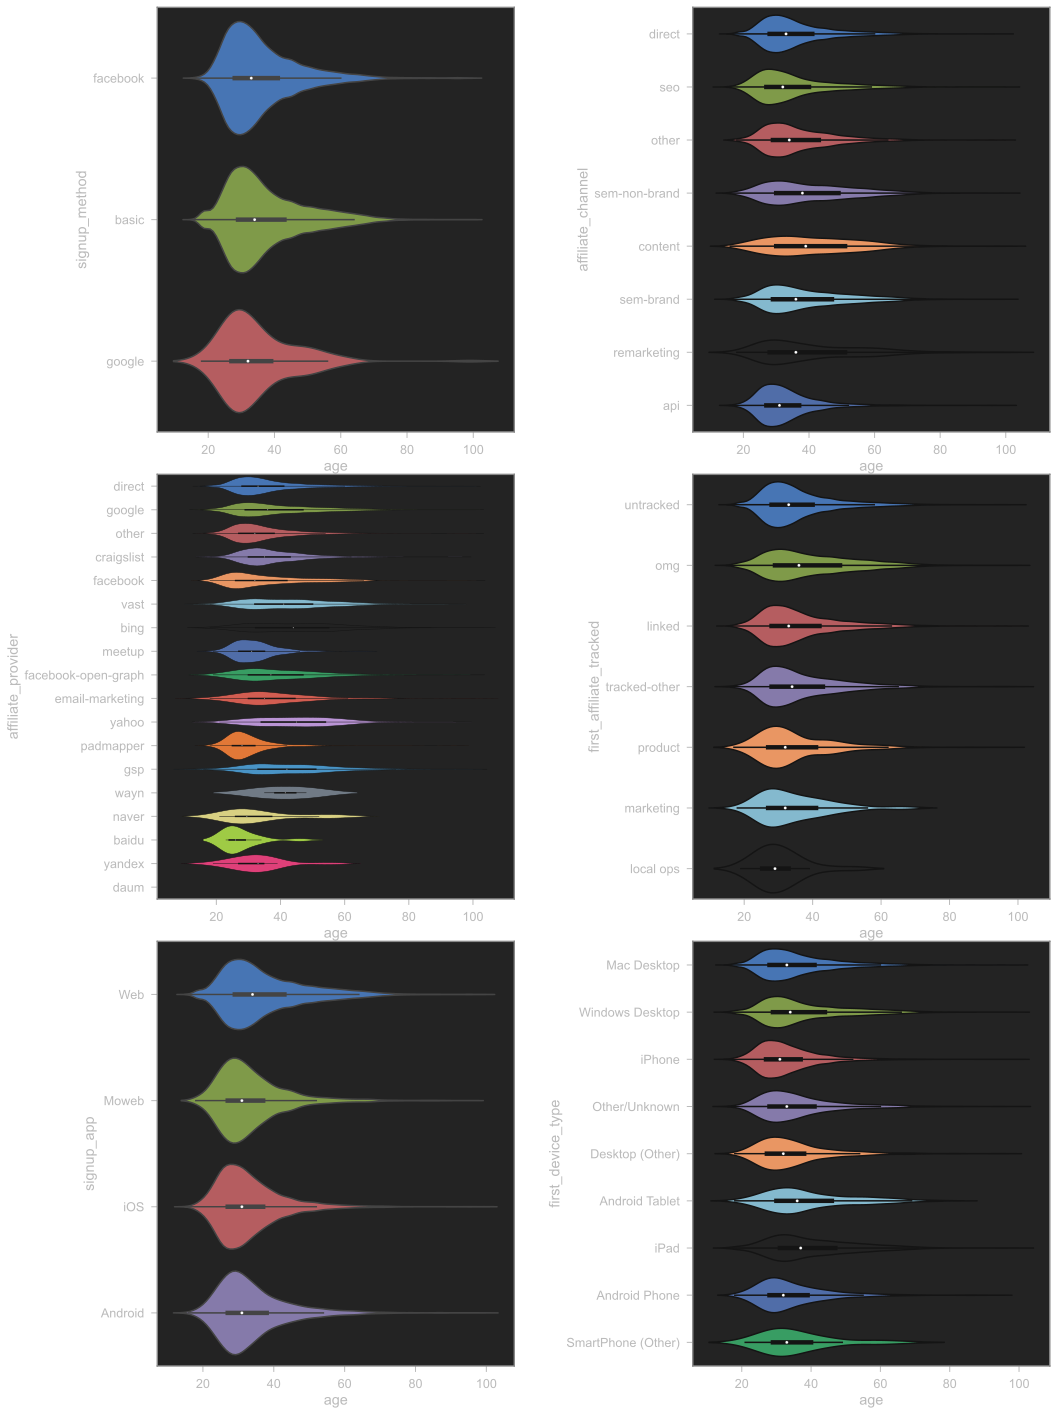

In [66]:
fig, ax = plt.subplots(nrows=3, ncols=2)
axes = ax.flatten()

sns.violinplot(train_users['age'], train_users['signup_method'], ax=axes[0])
sns.violinplot(train_users['age'], train_users['affiliate_channel'], ax=axes[1])
sns.violinplot(train_users['age'], train_users['affiliate_provider'], linewidth=0.5, width=1.2, ax=axes[2])
sns.violinplot(train_users['age'], train_users['first_affiliate_tracked'], ax=axes[3])
sns.violinplot(train_users['age'], train_users['signup_app'], ax=axes[4])
sns.violinplot(train_users['age'], train_users['first_device_type'], ax=axes[5])

fig.set_size_inches(16, 25)
plt.subplots_adjust(wspace=0.5, hspace=0.1)
plt.show()

![title](img/age_method_chan.png)
![title](img/age_affiliate.png)
![title](img/age_signup_firstdev.png)

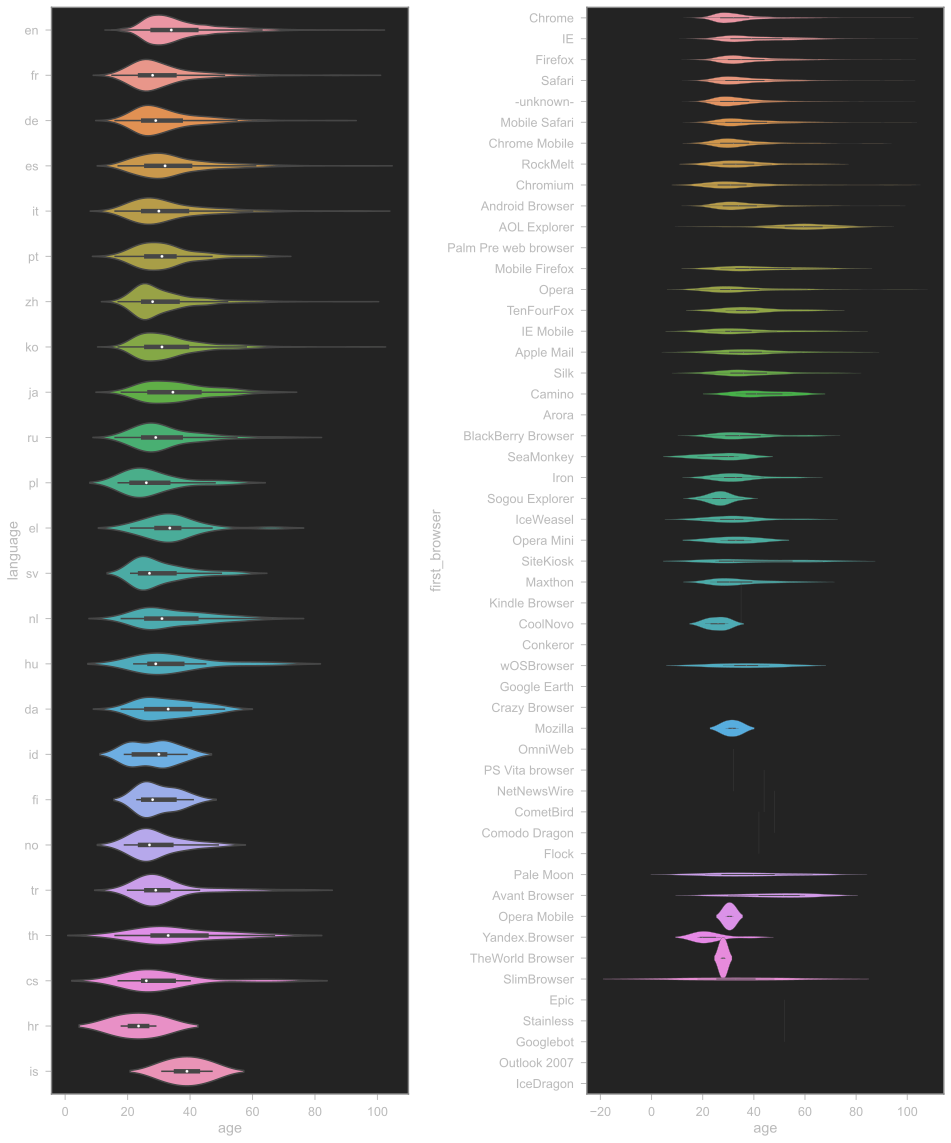

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2)
axes = ax.flatten()

sns.violinplot(train_users['age'], train_users['language'], ax=axes[0])
sns.violinplot(train_users['age'], train_users['first_browser'], linewidth=0.3, width=2, ax=axes[1])

fig.set_size_inches(16, 20)
plt.subplots_adjust(wspace=0.5, hspace=0.1)
plt.show()

![title](img/age_lang_firstbr.png)

### 1.2.3 COUNT_FEATURES - TARGET

In [8]:
def counter(df: pd.DataFrame,
            first_group_col: str,
            second_group_col: str,
           ) -> pd.DataFrame:
    """
    Function for categorical features counter and comparing them with target one
    """
    grouped_df = df.groupby([first_group_col, second_group_col])[second_group_col].agg('count').rename('count')
    return grouped_df.reset_index().pivot_table(values='count', index=second_group_col, columns=first_group_col).fillna(0)

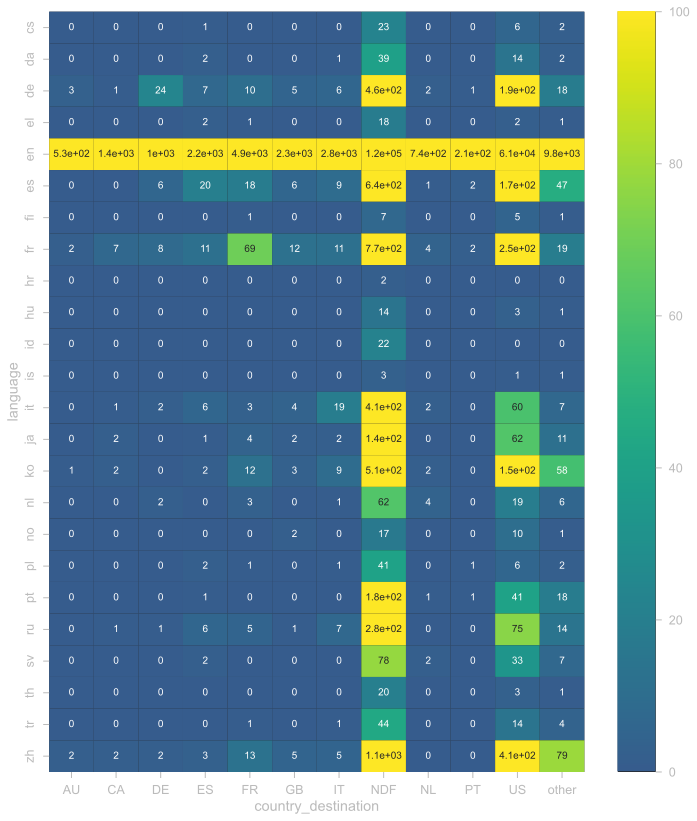

In [69]:
plt.figure(figsize=(12, 14))
sns.heatmap(counter(df=train_users, first_group_col='country_destination', second_group_col='language'), vmin=0, vmax=100, center=30, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/counter_1.png)

En-lang have no preferences in country destination. The most popular directions are US and NDF. Lets check other cat. features

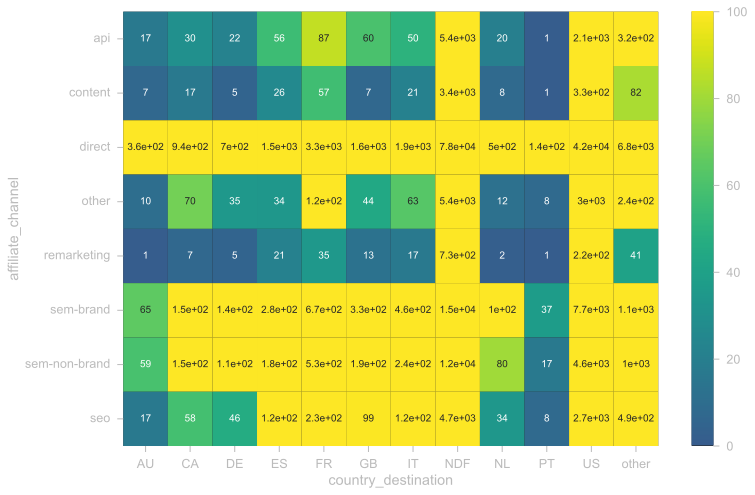

In [70]:
plt.figure(figsize=(12, 8))
sns.heatmap(counter(df=train_users, first_group_col='country_destination', second_group_col='affiliate_channel'), vmin=0, vmax=100, center=30, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/counter_2.png)

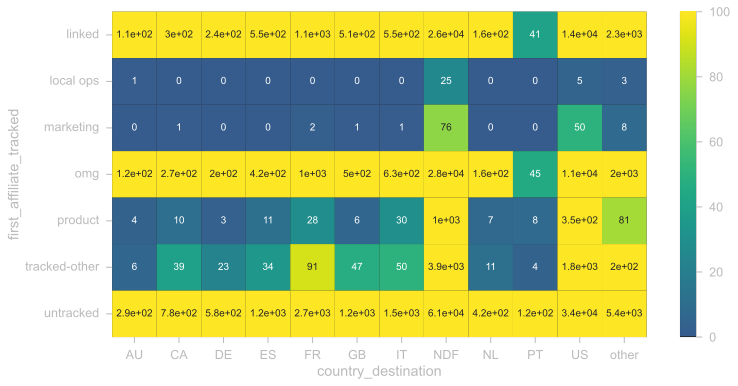

In [71]:
plt.figure(figsize=(12, 6))
sns.heatmap(counter(df=train_users, first_group_col='country_destination', second_group_col='first_affiliate_tracked'), vmin=0, vmax=100, center=30, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/counter_3.png)

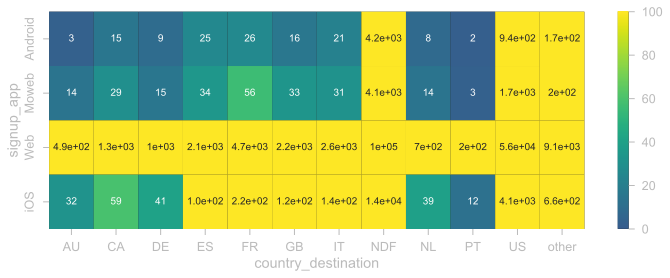

In [72]:
plt.figure(figsize=(12, 4))
sns.heatmap(counter(df=train_users, first_group_col='country_destination', second_group_col='signup_app'), vmin=0, vmax=100, center=30, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/counter_4.png)

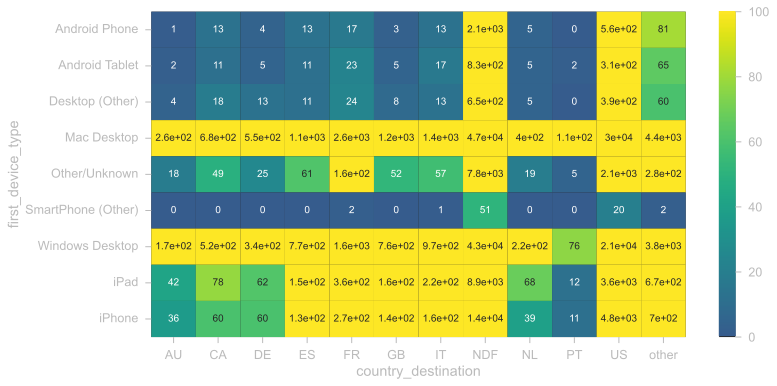

In [73]:
plt.figure(figsize=(12, 6))
sns.heatmap(counter(df=train_users, first_group_col='country_destination', second_group_col='first_device_type'), vmin=0, vmax=100, center=30, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/counter_5.png)

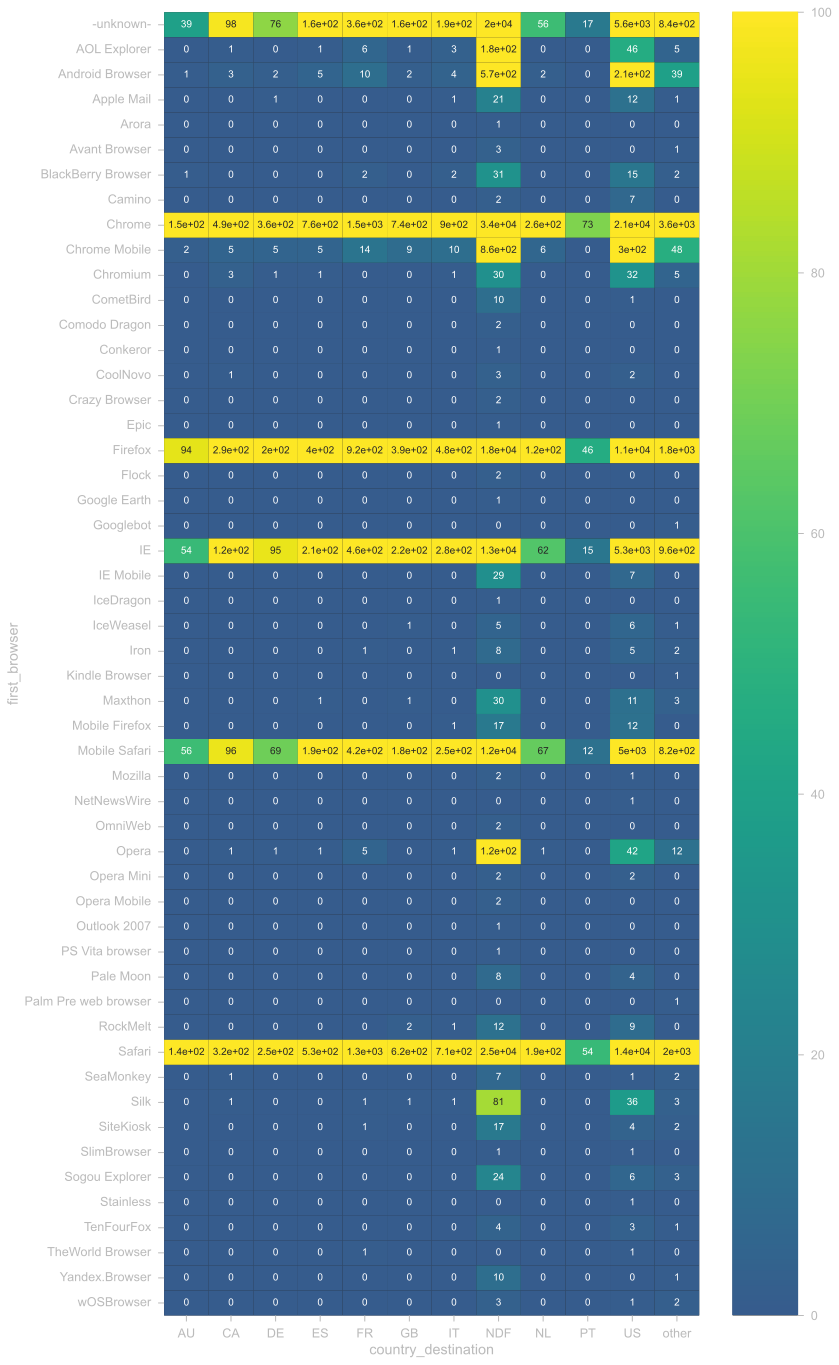

In [74]:
plt.figure(figsize=(12, 24))
sns.heatmap(counter(df=train_users, first_group_col='country_destination', second_group_col='first_browser'), vmin=0, vmax=100, center=30, annot=True, fmt='.2g', cmap='viridis')
plt.show()

![title](img/counter_6.png)

---

## 2. Baseline model
Create easy baseline model (for time saving LightGBM was chosen) to fix base metric

In [42]:
def score_model(train_model: callable,
                X_score: pd.DataFrame,
                y_score: np.ndarray,
                k: int=5) -> float:
    """
    NDCG score function @k
    :param train_model: Input model supported .predict_proba()/xgb.predict() (note the metric is needed probs of each class for ranking!)
    :param X_score:     X data for predicti and followed by scoring
    :param y_score:     labels for scoring
    """
    try:
        # For CatBoost and LightGBM models
        score = ndcg_score(pd.get_dummies(y_score).to_numpy(), train_model.predict_proba(X_score), k=k)
    except AttributeError as e:
        # For XGB model (XGBoost API!)
        X_score = xgb.DMatrix(data=X_score, enable_categorical=True)
        score = ndcg_score(pd.get_dummies(y_score).to_numpy(), train_model.predict(X_score), k=k)
    return score

In [43]:
le = LabelEncoder()
ohe = OneHotEncoder()
# classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

In [44]:
X_train_data = train_users.drop(columns=['id', 'country_destination', 'date_first_booking', 'date_account_created', 'timestamp_first_active', 'age_group'])
y_train_data = le.fit_transform(train_users['country_destination'])

# Split dataset for Hold-out validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=128)

string_cols = X_train.select_dtypes(exclude=[np.number]).columns
X_train[string_cols] = X_train[string_cols].astype('category')
X_valid[string_cols] = X_valid[string_cols].astype('category')

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((170760, 11), (42691, 11), (170760,), (42691,))

In [45]:
lgb_params = {"n_estimators": 1500,
               "max_depth": 5,
               "n_jobs": -1,
               "reg_lambda": 5,
               "random_state": 128,
#               "class_weight": 'balanced',
             }

lgb_model_baseline = lgb.LGBMClassifier(**lgb_params)
lgb_model_baseline.fit(X_train, y_train,
                       early_stopping_rounds=100, 
                       eval_set=[(X_train, y_train), (X_valid, y_valid)],
                       verbose=100)

[100]	training's multi_logloss: 1.0368	valid_1's multi_logloss: 1.053


LGBMClassifier(max_depth=5, n_estimators=1500, random_state=128, reg_lambda=5)

Train score: 0.8289, Valid score: 0.827


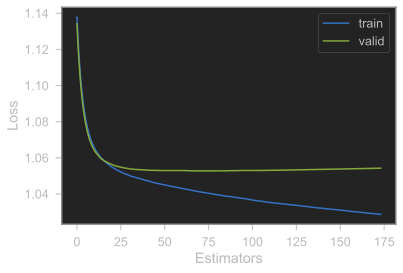

In [46]:
train_score = score_model(lgb_model_baseline, X_train, y_train)
valid_score = score_model(lgb_model_baseline, X_valid, y_valid)
print(f'Train score: {train_score:.4}, Valid score: {valid_score:.4}')

plt.plot(lgb_model_baseline.evals_result_['training']['multi_logloss'], label='train')
plt.plot(lgb_model_baseline.evals_result_['valid_1']['multi_logloss'], label='valid')
plt.xlabel("Estimators")
plt.ylabel('Loss')
plt.legend()
plt.show()

![title](img/baseline_loss.png)

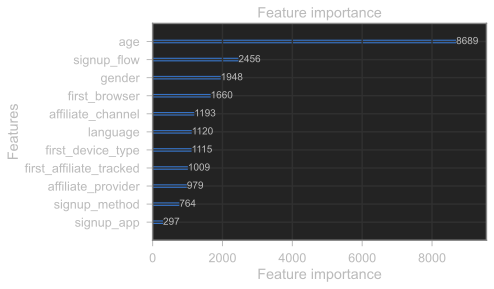

In [14]:
lgb.plot_importance(lgb_model_baseline)

![title](img/baseline_featimp.png)

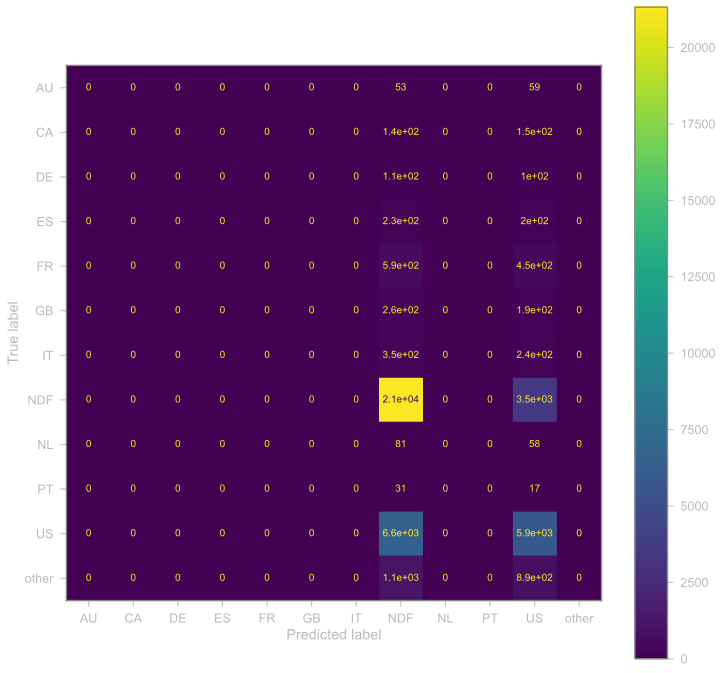

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
disp = ConfusionMatrixDisplay(confusion_matrix(y_valid, lgb_model_baseline.predict(X_valid)), display_labels=le.inverse_transform(range(len(set(y_train)))))
disp.plot(ax=ax, values_format ='.2g')
plt.show()

![title](img/baseline_confusion.png)

---

## 3. Feature Generation

### 3.1 ARTIFICIALLY SIMULATED FEATURES

In [47]:
# Previous EDA code for convinience
train_users = pd.read_csv('train_users_2.csv')

train_users['gender'] = train_users['gender'].apply(lambda x: x.lower())
train_users.loc[train_users['language'] == 'ca', 'language'] = 'en'
train_users['timestamp_first_active'] = pd.to_datetime(train_users['timestamp_first_active'], format='%Y%m%d%H%M%S')
train_users['date_account_created'] = train_users['date_account_created'].astype('datetime64[ns]')
train_users['date_first_booking'] = train_users['date_first_booking'].astype('datetime64[ns]')

train_users.loc[train_users['age'] > 1900, 'age'] = 2015 - train_users['age']
train_users.loc[(train_users['age'] > 100) | (train_users['age'] < 15), 'age'] = np.nan

train_users['age_group'] = np.nan
train_users.loc[train_users['age'] < 4, 'age_group'] = '0-4'
train_users.loc[(train_users['age'] >= 5) & (train_users['age'] < 9), 'age_group'] = '5-9'
train_users.loc[(train_users['age'] >= 10) & (train_users['age'] < 14), 'age_group'] = '10-14'
train_users.loc[(train_users['age'] >= 15) & (train_users['age'] < 19), 'age_group'] = '15-19'
train_users.loc[(train_users['age'] >= 20) & (train_users['age'] < 24), 'age_group'] = '20-24'
train_users.loc[(train_users['age'] >= 25) & (train_users['age'] < 29), 'age_group'] = '25-29'
train_users.loc[(train_users['age'] >= 30) & (train_users['age'] < 34), 'age_group'] = '30-34'
train_users.loc[(train_users['age'] >= 35) & (train_users['age'] < 39), 'age_group'] = '35-39'
train_users.loc[(train_users['age'] >= 40) & (train_users['age'] < 44), 'age_group'] = '40-44'
train_users.loc[(train_users['age'] >= 45) & (train_users['age'] < 49), 'age_group'] = '45-49'
train_users.loc[(train_users['age'] >= 50) & (train_users['age'] < 54), 'age_group'] = '50-54'
train_users.loc[(train_users['age'] >= 55) & (train_users['age'] < 59), 'age_group'] = '55-59'
train_users.loc[(train_users['age'] >= 60) & (train_users['age'] < 64), 'age_group'] = '60-64'
train_users.loc[(train_users['age'] >= 65) & (train_users['age'] < 69), 'age_group'] = '65-69'
train_users.loc[(train_users['age'] >= 70) & (train_users['age'] < 74), 'age_group'] = '70-74'
train_users.loc[(train_users['age'] >= 75) & (train_users['age'] < 79), 'age_group'] = '75-79'
train_users.loc[(train_users['age'] >= 80) & (train_users['age'] < 84), 'age_group'] = '80-84'
train_users.loc[(train_users['age'] >= 85) & (train_users['age'] < 89), 'age_group'] = '85-89'
train_users.loc[(train_users['age'] >= 90) & (train_users['age'] < 94), 'age_group'] = '90-94'
train_users.loc[(train_users['age'] >= 95) & (train_users['age'] < 99), 'age_group'] = '95-99'
train_users.loc[train_users['age'] >= 100, 'age_group'] = '100+'

0.4244718738322365

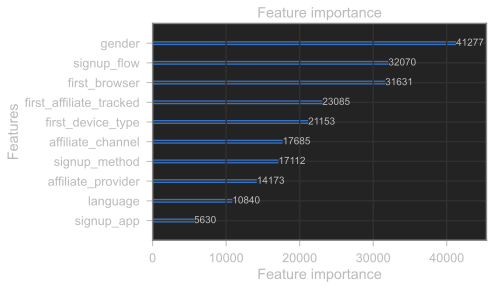

In [48]:
# Features fitting
# FEATURE obtained by weighted boosting model from initial dataset without dominant (high weight) AGE feature
X_train_data = train_users.drop(columns=['id', 'country_destination', 'date_first_booking', 'date_account_created', 'timestamp_first_active', 'age_group', 'age'])
y_train_data = le.fit_transform(train_users['country_destination'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=128)
string_cols = X_train.select_dtypes(exclude=[np.number]).columns
X_train[string_cols] = X_train[string_cols].astype('category')
X_valid[string_cols] = X_valid[string_cols].astype('category')

lgb_params_weighted = {"n_estimators": 1500,
                       "max_depth": 5,
                       "n_jobs": -1,
                       "reg_lambda": 5,
                       "class_weight": 'balanced',
                       "random_state": 128,
                      }

lgb_model_weighted = lgb.LGBMClassifier(**lgb_params_weighted)
lgb_model_weighted.fit(X_train, y_train,
                       early_stopping_rounds=100, 
                       eval_set=[(X_train, y_train), (X_valid, y_valid)],
                       verbose=0)

lgb.plot_importance(lgb_model_weighted)
score_model(lgb_model_weighted, X_valid, y_valid)

![title](img/weighted_featimp.png)

In [49]:
# Features matrix transform
X_train_data = train_users.drop(columns=['id', 'country_destination', 'date_first_booking', 'date_account_created', 'timestamp_first_active', 'age_group', 'age'])
X_train_data[string_cols] = X_train_data[string_cols].astype('category')
train_users['weighted_feature'] = lgb_model_weighted.predict(X_train_data)

### 3.2 FEATURES FROM train and sessions

In [50]:
# Features fitting
secs_elapsed_stats = sessions.groupby('user_id').agg(min=('secs_elapsed', np.min), 
                                                     max=('secs_elapsed', np.max), 
                                                     mean=('secs_elapsed', np.mean),
                                                     median=('secs_elapsed', np.median),
                                                     std=('secs_elapsed', np.std),
                                                    ).fillna(0).add_prefix('secs_elapsed_')

age_first_browser = train_users.groupby('first_browser')[['age']].agg(np.median).reset_index()
age_language = train_users.groupby('language')[['age']].agg(np.median).reset_index()
age_affiliate_provider = train_users.groupby('affiliate_provider')[['age']].agg(np.median).reset_index()

total_actions_counter = sessions.groupby('user_id').agg('count').add_suffix('_count')

action_detail_counter = counter(df=sessions, first_group_col='action_detail', second_group_col='user_id').add_prefix('action_detail_')
action_type_counter = counter(df=sessions, first_group_col='action_type', second_group_col='user_id').add_prefix('action_type_')
device_type_counter = counter(df=sessions, first_group_col='device_type', second_group_col='user_id').add_prefix('device_type_')
action_counter = counter(df=sessions, first_group_col='action', second_group_col='user_id').add_prefix('action_')

language_counter = counter(df=train_users, first_group_col='country_destination', second_group_col='language').add_prefix('language_')
first_browser_counter = counter(df=train_users, first_group_col='country_destination', second_group_col='first_browser').add_prefix('first_browser_')
first_device_type_counter = counter(df=train_users, first_group_col='country_destination', second_group_col='first_device_type').add_prefix('first_device_type_')
signup_app_counter = counter(df=train_users, first_group_col='country_destination', second_group_col='signup_app').add_prefix('signup_app_')
first_affiliate_tracked_counter = counter(df=train_users, first_group_col='country_destination', second_group_col='first_affiliate_tracked').add_prefix('first_affiliate_tracked_')
affiliate_channel_counter = counter(df=train_users, first_group_col='country_destination', second_group_col='affiliate_channel').add_prefix('affiliate_channel_')

language_age_group_counter = train_users.pivot_table(index=['language', 'age_group'], columns='country_destination', values='id', aggfunc='count').fillna(0).add_prefix('language_age_group_')
first_brows_device_type_signup_counter = train_users.pivot_table(index=['first_browser', 'first_device_type', 'signup_app'], columns='country_destination', values='id', aggfunc='count').fillna(0).add_prefix('first_brows_device_type_signup_')
first_affiliate_tracked_affiliate_channel_counter = train_users.pivot_table(index=['first_affiliate_tracked', 'affiliate_channel'], columns='country_destination', values='id', aggfunc='count').fillna(0).add_prefix('first_affiliate_tracked_affiliate_channel_')

In [51]:
# Features matrix transform
train_users['year_account_created'] = train_users['date_account_created'].dt.year.astype('int32')
train_users['month_account_created'] = train_users['date_account_created'].dt.month.astype('int32')
train_users['day_account_created'] = train_users['date_account_created'].dt.day.astype('int32')
train_users['weekday_account_created'] = train_users['date_account_created'].dt.weekday
train_users['year_first_active'] = train_users['timestamp_first_active'].dt.year.astype('int32')
train_users['month_first_active'] = train_users['timestamp_first_active'].dt.month.astype('int32')
train_users['day_first_active'] = train_users['timestamp_first_active'].dt.day.astype('int32')
train_users['weekday_first_active'] = train_users['timestamp_first_active'].dt.weekday

train_users = pd.merge(train_users, secs_elapsed_stats, how='left', left_on='id', right_on='user_id')

train_users['global_device'] = np.nan
train_users.loc[np.isin(train_users['first_device_type'], ['Mac Desktop', 'Windows Desktop', 'Desktop (Other)']), 'global_device'] = 'pc'
train_users.loc[np.isin(train_users['first_device_type'], ['iPhone', 'Android Tablet', 'iPad', 'Android Phone', 'SmartPhone (Other)']), 'global_device'] = 'mobile'
train_users.loc[np.isin(train_users['first_device_type'], ['Other/Unknown']), 'global_device'] = 'other'

train_users = pd.merge(train_users, age_first_browser, how='left', on='first_browser', suffixes=('', '_first_browser'))
train_users = pd.merge(train_users, age_language, how='left', on='language', suffixes=('', '_language'))
train_users = pd.merge(train_users, age_affiliate_provider, how='left', on='affiliate_provider', suffixes=('', '_affiliated_provider'))

train_users = pd.merge(train_users, total_actions_counter, how='left', left_on='id', right_on='user_id')

train_users = pd.merge(train_users, action_type_counter, how='left', left_on='id', right_on='user_id')
train_users = pd.merge(train_users, action_detail_counter, how='left', left_on='id', right_on='user_id')
train_users = pd.merge(train_users, action_counter, how='left', left_on='id', right_on='user_id')
train_users = pd.merge(train_users, device_type_counter, how='left', left_on='id', right_on='user_id')

train_users = pd.merge(train_users, language_counter, how='left', on='language')
train_users = pd.merge(train_users, first_browser_counter, how='left', on='first_browser')
train_users = pd.merge(train_users, first_device_type_counter, how='left',on='first_device_type')
train_users = pd.merge(train_users, signup_app_counter, how='left', on='signup_app')
train_users = pd.merge(train_users, first_affiliate_tracked_counter, how='left',on='first_affiliate_tracked')
train_users = pd.merge(train_users, affiliate_channel_counter, how='left', on='affiliate_channel')

train_users = pd.merge(train_users, language_age_group_counter, how='left', on=['language', 'age_group'])
train_users = pd.merge(train_users, first_brows_device_type_signup_counter, how='left', on=['first_browser', 'first_device_type', 'signup_app'])
train_users = pd.merge(train_users, first_affiliate_tracked_affiliate_channel_counter, how='left', on=['first_affiliate_tracked', 'affiliate_channel'])

train_users.shape

(213451, 686)

### 3.3 TARGET FEATURES FROM countries and age_gender_bkts
Create aggregated pivot tables from numericals values in target tables (countries, age_gender_bkts) relying on categories and labels in the train one (train_users)

In [ ]:
countries['destination_language '] = countries['destination_language '].apply(lambda x: x[:2])
targets = pd.merge(countries, age_gender_bkts.groupby('country_destination')[['population_in_thousands']].agg(np.sum), how='left', on='country_destination')
temporary_data = pd.merge(train_users, targets.drop(columns='destination_language '), how='left', on='country_destination').dropna(subset=['population_in_thousands'])
index_list = ['language', 'first_browser', 'first_device_type', 'signup_app', 'first_affiliate_tracked', 'affiliate_channel']
values_list = ['population_in_thousands', 'language_levenshtein_distance', 'destination_km2', 'distance_km', 'lng_destination', 'lat_destination']

In [52]:
# Mass feature generator
for index in index_list:
    for value in values_list:
        aggregated_table = temporary_data.pivot_table(index=index,
                                                      columns='country_destination',
                                                      values=value,
                                                      aggfunc='median').fillna(0).add_prefix(f'{index}_{value}_')
        train_users = pd.merge(train_users, aggregated_table, how='left', on=index)

train_users.shape

(213451, 1046)

### 3.4 Check the accuracy metric

In [54]:
X_train_data = train_users.drop(columns=['id', 'country_destination', 'date_first_booking', 'date_account_created', 'timestamp_first_active'])
y_train_data = le.fit_transform(train_users['country_destination'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=128)
string_cols = X_train.select_dtypes(exclude=[np.number]).columns
X_train[string_cols] = X_train[string_cols].astype('category')
X_valid[string_cols] = X_valid[string_cols].astype('category')

lgb_params = {"n_estimators": 1500,
               "max_depth": 5,
               "n_jobs": -1,
               "reg_lambda": 5,
#                "learning_rate": 0.1,
               "random_state": 128,
              }

lgb_model_ = lgb.LGBMClassifier(**lgb_params)
lgb_model_.fit(X_train, y_train,
               early_stopping_rounds=100, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)],
               verbose=100)

train_score = score_model(lgb_model_, X_train, y_train)
valid_score = score_model(lgb_model_, X_valid, y_valid)
print(f'Train score: {train_score:.4}, Valid score: {valid_score:.4}')

[100]	training's multi_logloss: 0.958329	valid_1's multi_logloss: 1.02986
[200]	training's multi_logloss: 0.928584	valid_1's multi_logloss: 1.0309
Train score: 0.8437, Valid score: 0.8318


Metric shows a bit increasing after adding new features, but there could be useless and harmful features...

---

## 4. Feature Selection

In [57]:
%%time
importance = permutation_importance(lgb_model_, X_valid, y_valid, scoring=score_model, n_jobs=-1, random_state=128)

CPU times: user 6min 44s, sys: 4.19 s, total: 6min 48s
Wall time: 3h 36min 6s


In [58]:
importance_scores = pd.DataFrame({"features": X_valid.columns,
                                  "importance-mean": importance.importances_mean,
                                  "importance-std": importance.importances_std})
importance_scores = importance_scores.sort_values(by="importance-mean", ascending=False).reset_index(drop=True)
importance_scores

features  importance-mean  importance-std
0                                   age         0.047779        0.000239
1                         signup_method         0.016093        0.000243
2           action_type_booking_request         0.003910        0.000221
3                           signup_flow         0.000997        0.000167
4                                gender         0.000569        0.000172
...                                 ...              ...             ...
1036       action_detail_user_wishlists        -0.000061        0.000015
1037  action_detail_update_user_profile        -0.000073        0.000051
1038               weekday_first_active        -0.000088        0.000087
1039                   secs_elapsed_std        -0.000091        0.000094
1040                   secs_elapsed_max        -0.000104        0.000044

[1041 rows x 3 columns]

In [74]:
# Delete useless features and retrain the model
feature_selection = importance_scores.loc[importance_scores['importance-mean'] > 0, 'features'].values
feature_selection.shape

(185,)

In [75]:
pd.DataFrame(importance_scores).to_csv("importance_scores.csv")
pd.DataFrame(feature_selection).to_csv("features.csv", index=False, header=False)

In [133]:
# importance_scores = pd.read_csv("importance_scores.csv", index_col=0)
# feature_selection = pd.read_csv("features.csv", header=None).to_numpy().flatten()

[100]	training's multi_logloss: 0.95961	valid_1's multi_logloss: 1.0291
Train score: 0.8425, Valid score: 0.832


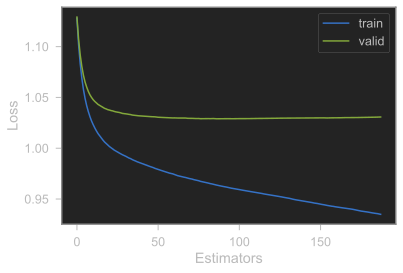

In [61]:
X_train_selected = X_train[feature_selection]
X_valid_selected = X_valid[feature_selection]
string_cols = X_train_selected.select_dtypes(exclude=[np.number]).columns
X_train_selected[string_cols] = X_train_selected[string_cols].astype("category")
X_valid_selected[string_cols] = X_valid_selected[string_cols].astype("category")

lgb_model_selected = lgb.LGBMClassifier(**lgb_params)
lgb_model_selected.fit(X_train_selected, y_train,
                       early_stopping_rounds=100, 
                       eval_set=[(X_train_selected, y_train), (X_valid_selected, y_valid)],
                       verbose=100)

train_score = score_model(lgb_model_selected, X_train_selected, y_train)
valid_score = score_model(lgb_model_selected, X_valid_selected, y_valid)
print(f'Train score: {train_score:.4}, Valid score: {valid_score:.4}')

plt.plot(lgb_model_selected.evals_result_['training']['multi_logloss'], label='train')
plt.plot(lgb_model_selected.evals_result_['valid_1']['multi_logloss'], label='valid')
plt.xlabel("Estimators")
plt.ylabel('Loss')
plt.legend()
plt.show()

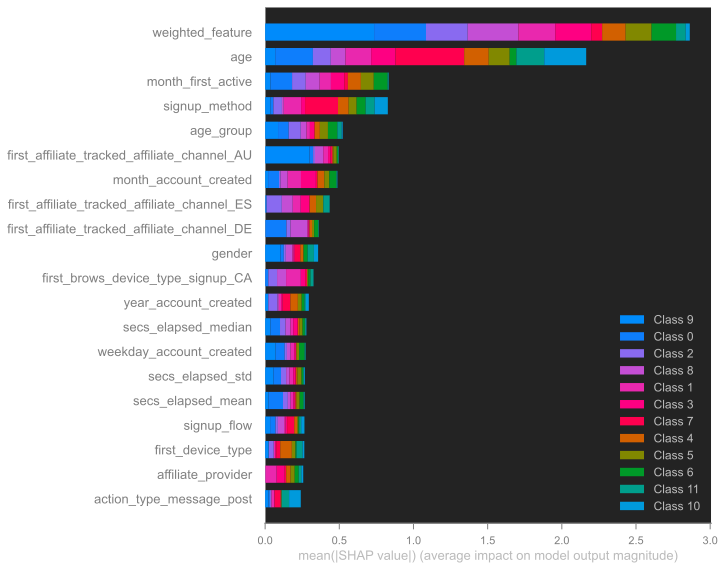

In [62]:
# top features
explainer = shap.TreeExplainer(lgb_model_)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid, axis_color='#808080')

![title](img/shapely_feature_importance.png)

The model got much easier becuase of reducing features from ~1000 up to ~150-200 without missing in accuracy score

---

# 5. Model Selection
Let's try to check the influence of models changing (CatBoost and XGBoost) on NCDG accuracy score

## 5.1 CatBoost

Learning rate set to 0.155944
0:	learn: 1.7986683	test: 1.7981773	best: 1.7981773 (0)	total: 2.92s	remaining: 24m 19s
100:	learn: 1.0134345	test: 1.0275984	best: 1.0275831 (99)	total: 5m 17s	remaining: 20m 52s
200:	learn: 1.0000931	test: 1.0257065	best: 1.0256368 (187)	total: 10m 46s	remaining: 16m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.025636771
bestIteration = 187

Shrink model to first 188 iterations.
Train score: 0.8359, Valid score: 0.8319


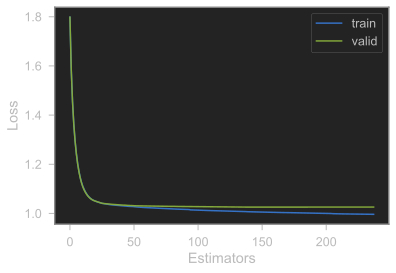

In [107]:
cb_params = {"n_estimators": 500,
             "objective": "MultiClass",
             "verbose": 100,
             "max_depth": 5,
             "early_stopping_rounds": 50,
             "thread_count": -1,
             "classes_count": 12,
             "random_state": 128,
            }

X_train_selected[string_cols] = X_train_selected[string_cols].astype('str')
X_valid_selected[string_cols] = X_valid_selected[string_cols].astype('str')

p_train = cb.Pool(data=X_train_selected, label=y_train, cat_features=string_cols.values)
p_valid = cb.Pool(data=X_valid_selected, label=y_valid, cat_features=string_cols.values)

cb_model_selected = cb.CatBoostClassifier(**cb_params)
cb_model_selected.fit(p_train, eval_set=p_valid)

train_score = score_model(cb_model_selected, X_train_selected, y_train)
valid_score = score_model(cb_model_selected, X_valid_selected, y_valid)
print(f'Train score: {train_score:.4}, Valid score: {valid_score:.4}')
plt.plot(cb_model_selected.get_evals_result()['learn']['MultiClass'], label='train')
plt.plot(cb_model_selected.get_evals_result()['validation']['MultiClass'], label='valid')
plt.xlabel("Estimators")
plt.ylabel('Loss')
plt.legend()
plt.show()

![title](img/catboost_model.png)

## 5.2 XGBoost

[00:08:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.74798	valid-mlogloss:1.74968
[80]	train-mlogloss:0.93565	valid-mlogloss:1.03230
Train score: 0.8475, Valid score: 0.832


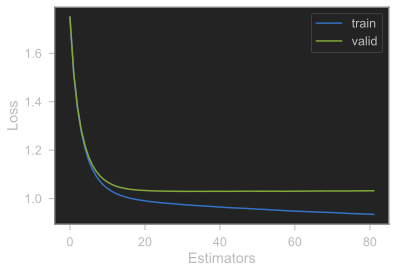

In [106]:
xgb_params = {"objective": "multi:softprob",
              "num_class": 12,
              "max_depth": 5,
              "n_jobs": -1,
              "random_state": 128,
             }

X_train_selected[string_cols] = X_train_selected[string_cols].astype("category")
X_valid_selected[string_cols] = X_valid_selected[string_cols].astype("category")

dm_train = xgb.DMatrix(data=X_train_selected, label=y_train, enable_categorical=True)
dm_valid = xgb.DMatrix(data=X_valid_selected, label=y_valid, enable_categorical=True)

evals_result = {}
xgb_model_selected = xgb.train(params=xgb_params,
                               dtrain=dm_train,
                               num_boost_round=500,
                               early_stopping_rounds=50,
                               evals=[(dm_train, "train"), (dm_valid, "valid")],
                               verbose_eval=100,
                               evals_result=evals_result,
                              )

train_score = score_model(xgb_model_selected, X_train_selected, y_train)
valid_score = score_model(xgb_model_selected, X_valid_selected, y_valid)
print(f'Train score: {train_score:.4}, Valid score: {valid_score:.4}')

plt.plot(evals_result['train']['mlogloss'], label='train')
plt.plot(evals_result['valid']['mlogloss'], label='valid')
plt.xlabel("Estimators")
plt.ylabel('Loss')
plt.legend()
plt.show()

![title](img/xgb_model.png)

### Short Sum (Models):
Scores of all models are comparable. The main difference is in training time (from less to high LightGBM -> XGBoost -> CatBoost).

---

# 6. Tuning of hyperparameters
Use Optuna for optimization

In [64]:
def objective(trial):

    lgb_params = {"boosting_type": 'gbdt',
                  "objective": 'multiclass',
                  "n_estimators": 1500,
                  "n_jobs": -1,
                  "random_state": 128,
                  # Tunning
                  "max_depth": trial.suggest_int("max_depth", 4, 10),
                  "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 30),
                  "min_sum_hessian_per_leaf": trial.suggest_float("min_sum_hessian_per_leaf", 0.001, 0.01),
                  "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1.0),
                  "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.),
                  "reg_alpha": trial.suggest_float("reg_alpha", 0., 5.),
                  "min_data_per_group": trial.suggest_int("min_data_per_group", 50, 200),
                  "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.),
                  "num_leaves": trial.suggest_int("num_leaves", 20, 50),
                 }
    
    X_train_selected = X_train[feature_selection]
    X_valid_selected = X_valid[feature_selection]

    string_cols = X_train_selected.select_dtypes(exclude=[np.number]).columns

    X_train_selected[string_cols] = X_train_selected[string_cols].astype("category")
    X_valid_selected[string_cols] = X_valid_selected[string_cols].astype("category")
    
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_train_selected, y_train, 
                  eval_set=[(X_train_selected, y_train), (X_valid_selected, y_valid)],
                  early_stopping_rounds=100,
                  verbose=-1,
                 )

    return score_model(lgb_model, X_valid_selected, y_valid)

In [65]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2021-12-03 21:40:45,707] A new study created in memory with name: no-name-e5c3a52f-6b05-48e7-a588-3cef1b5b5bbf


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006236115968431182 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=21. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.9043345103590708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043345103590708


[I 2021-12-03 21:41:09,635] Trial 0 finished with value: 0.8249434187364713 and parameters: {'max_depth': 8, 'min_samples_leaf': 21, 'min_sum_hessian_per_leaf': 0.006236115968431182, 'feature_fraction': 0.9043345103590708, 'reg_lambda': 0.3393589676562298, 'reg_alpha': 1.9782580892528805, 'min_data_per_group': 145, 'learning_rate': 0.6416804164090245, 'num_leaves': 26}. Best is trial 0 with value: 0.8249434187364713.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008767658710385484 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.9029101625283773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9029101625283773


[I 2021-12-03 21:41:33,743] Trial 1 finished with value: 0.830229566663156 and parameters: {'max_depth': 4, 'min_samples_leaf': 15, 'min_sum_hessian_per_leaf': 0.008767658710385484, 'feature_fraction': 0.9029101625283773, 'reg_lambda': 6.726926239180413, 'reg_alpha': 2.5937098161018275, 'min_data_per_group': 174, 'learning_rate': 0.7219079803803462, 'num_leaves': 30}. Best is trial 1 with value: 0.830229566663156.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0039125036018223215 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=19. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.9905961864274232, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9905961864274232


[I 2021-12-03 21:42:04,691] Trial 2 finished with value: 0.8299496225482786 and parameters: {'max_depth': 10, 'min_samples_leaf': 19, 'min_sum_hessian_per_leaf': 0.0039125036018223215, 'feature_fraction': 0.9905961864274232, 'reg_lambda': 5.387841460231636, 'reg_alpha': 3.61386833181615, 'min_data_per_group': 127, 'learning_rate': 0.8723223929870757, 'num_leaves': 34}. Best is trial 1 with value: 0.830229566663156.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008564595243173507 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=11. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.9207180025067817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9207180025067817


[I 2021-12-03 21:42:34,500] Trial 3 finished with value: 0.8301453981333485 and parameters: {'max_depth': 5, 'min_samples_leaf': 11, 'min_sum_hessian_per_leaf': 0.008564595243173507, 'feature_fraction': 0.9207180025067817, 'reg_lambda': 3.888665163139228, 'reg_alpha': 2.5967570435666323, 'min_data_per_group': 183, 'learning_rate': 0.6701464512750129, 'num_leaves': 49}. Best is trial 1 with value: 0.830229566663156.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005099793256098957 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=28. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.9640925705773588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9640925705773588


[I 2021-12-03 21:43:05,042] Trial 4 finished with value: 0.8318652356210533 and parameters: {'max_depth': 8, 'min_samples_leaf': 28, 'min_sum_hessian_per_leaf': 0.005099793256098957, 'feature_fraction': 0.9640925705773588, 'reg_lambda': 9.102020997427326, 'reg_alpha': 0.972901457435888, 'min_data_per_group': 197, 'learning_rate': 0.37953441198372806, 'num_leaves': 26}. Best is trial 4 with value: 0.8318652356210533.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009444069935902834 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8139390160651162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8139390160651162


[I 2021-12-03 21:43:31,536] Trial 5 finished with value: 0.8297038564453894 and parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'min_sum_hessian_per_leaf': 0.009444069935902834, 'feature_fraction': 0.8139390160651162, 'reg_lambda': 2.830402333522646, 'reg_alpha': 0.08094082801898439, 'min_data_per_group': 55, 'learning_rate': 0.7768779269993878, 'num_leaves': 22}. Best is trial 4 with value: 0.8318652356210533.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.003796449106199924 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8046741984118259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8046741984118259


[I 2021-12-03 21:44:04,436] Trial 6 finished with value: 0.8313250045908218 and parameters: {'max_depth': 6, 'min_samples_leaf': 25, 'min_sum_hessian_per_leaf': 0.003796449106199924, 'feature_fraction': 0.8046741984118259, 'reg_lambda': 0.9702096030128731, 'reg_alpha': 1.2325315236109806, 'min_data_per_group': 198, 'learning_rate': 0.31822603401811206, 'num_leaves': 32}. Best is trial 4 with value: 0.8318652356210533.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008206297844881777 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=22. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.9941237493493948, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9941237493493948


[I 2021-12-03 21:44:41,647] Trial 7 finished with value: 0.8295520543239003 and parameters: {'max_depth': 7, 'min_samples_leaf': 22, 'min_sum_hessian_per_leaf': 0.008206297844881777, 'feature_fraction': 0.9941237493493948, 'reg_lambda': 8.765716994655158, 'reg_alpha': 0.21467379479749638, 'min_data_per_group': 119, 'learning_rate': 0.7737253545925848, 'num_leaves': 42}. Best is trial 4 with value: 0.8318652356210533.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00607904497472116 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.9222348310619293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9222348310619293


[I 2021-12-03 21:45:16,051] Trial 8 finished with value: 0.8290416858968738 and parameters: {'max_depth': 9, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.00607904497472116, 'feature_fraction': 0.9222348310619293, 'reg_lambda': 4.009873799424454, 'reg_alpha': 3.1336650451956283, 'min_data_per_group': 133, 'learning_rate': 0.8282508511913393, 'num_leaves': 31}. Best is trial 4 with value: 0.8318652356210533.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004913844399725052 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.9308539579119072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9308539579119072


[I 2021-12-03 21:46:06,014] Trial 9 finished with value: 0.8323483693324439 and parameters: {'max_depth': 7, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.004913844399725052, 'feature_fraction': 0.9308539579119072, 'reg_lambda': 3.323236345312554, 'reg_alpha': 2.7327278796049717, 'min_data_per_group': 60, 'learning_rate': 0.10667186922215459, 'num_leaves': 44}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0011841379434806708 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.854094829974437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.854094829974437


[I 2021-12-03 21:49:31,175] Trial 10 finished with value: 0.8319341854091771 and parameters: {'max_depth': 7, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.0011841379434806708, 'feature_fraction': 0.854094829974437, 'reg_lambda': 2.314550383937496, 'reg_alpha': 4.712016714535842, 'min_data_per_group': 50, 'learning_rate': 0.010458256673316152, 'num_leaves': 41}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.001278375083149975 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8433937336846113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8433937336846113


[I 2021-12-03 21:52:51,870] Trial 11 finished with value: 0.8319101676182816 and parameters: {'max_depth': 7, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.001278375083149975, 'feature_fraction': 0.8433937336846113, 'reg_lambda': 2.3976214108671017, 'reg_alpha': 4.701753814854667, 'min_data_per_group': 52, 'learning_rate': 0.011275202122713265, 'num_leaves': 41}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0015277389935625134 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8627861180284571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627861180284571


[I 2021-12-03 21:54:33,047] Trial 12 finished with value: 0.8317772226471163 and parameters: {'max_depth': 6, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.0015277389935625134, 'feature_fraction': 0.8627861180284571, 'reg_lambda': 2.178642864748042, 'reg_alpha': 4.9958293893951, 'min_data_per_group': 85, 'learning_rate': 0.027477516012532913, 'num_leaves': 41}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.002913388484932883 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8661844543475453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8661844543475453


[I 2021-12-03 21:55:21,924] Trial 13 finished with value: 0.8319135850020754 and parameters: {'max_depth': 8, 'min_samples_leaf': 15, 'min_sum_hessian_per_leaf': 0.002913388484932883, 'feature_fraction': 0.8661844543475453, 'reg_lambda': 5.807110531469019, 'reg_alpha': 4.0052838342838015, 'min_data_per_group': 80, 'learning_rate': 0.18820176299625244, 'num_leaves': 48}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007069896321033872 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=24. Current value: min_data_in_leaf=24
[LightGBM] [Warning] feature_fraction is set=0.9517182761968628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9517182761968628


[I 2021-12-03 21:55:59,273] Trial 14 finished with value: 0.831577516641018 and parameters: {'max_depth': 5, 'min_samples_leaf': 24, 'min_sum_hessian_per_leaf': 0.007069896321033872, 'feature_fraction': 0.9517182761968628, 'reg_lambda': 3.805366956635913, 'reg_alpha': 4.177231029477708, 'min_data_per_group': 78, 'learning_rate': 0.17338168455060432, 'num_leaves': 45}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00251595941810036 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8752134901761246, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8752134901761246


[I 2021-12-03 21:56:38,673] Trial 15 finished with value: 0.8317298737114014 and parameters: {'max_depth': 10, 'min_samples_leaf': 18, 'min_sum_hessian_per_leaf': 0.00251595941810036, 'feature_fraction': 0.8752134901761246, 'reg_lambda': 1.2377425104415536, 'reg_alpha': 1.8446623837080134, 'min_data_per_group': 102, 'learning_rate': 0.17241684916567757, 'num_leaves': 38}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004713685396471847 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.8373576591525945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8373576591525945


[I 2021-12-03 21:57:13,564] Trial 16 finished with value: 0.8311665282671461 and parameters: {'max_depth': 7, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.004713685396471847, 'feature_fraction': 0.8373576591525945, 'reg_lambda': 6.619518722598924, 'reg_alpha': 3.29182455651918, 'min_data_per_group': 67, 'learning_rate': 0.5011575441994337, 'num_leaves': 37}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.002506632675638679 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=30. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9375234338169304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9375234338169304


[I 2021-12-03 21:57:52,280] Trial 17 finished with value: 0.8314638587027011 and parameters: {'max_depth': 9, 'min_samples_leaf': 30, 'min_sum_hessian_per_leaf': 0.002506632675638679, 'feature_fraction': 0.9375234338169304, 'reg_lambda': 1.7114305230190507, 'reg_alpha': 4.2995873700911185, 'min_data_per_group': 96, 'learning_rate': 0.30586643314473827, 'num_leaves': 46}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007644663366860198 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8825226868415295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8825226868415295


[I 2021-12-03 21:58:24,515] Trial 18 finished with value: 0.8279894832373428 and parameters: {'max_depth': 5, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.007644663366860198, 'feature_fraction': 0.8825226868415295, 'reg_lambda': 3.3534875800876955, 'reg_alpha': 3.053373033105061, 'min_data_per_group': 63, 'learning_rate': 0.9843052487556023, 'num_leaves': 44}. Best is trial 9 with value: 0.8323483693324439.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.003921840187489798 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=12. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8404241224426715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8404241224426715


[I 2021-12-03 21:59:18,227] Trial 19 finished with value: 0.8323597565361738 and parameters: {'max_depth': 9, 'min_samples_leaf': 12, 'min_sum_hessian_per_leaf': 0.003921840187489798, 'feature_fraction': 0.8404241224426715, 'reg_lambda': 4.563276718931919, 'reg_alpha': 1.8403873510494728, 'min_data_per_group': 106, 'learning_rate': 0.10082050352076388, 'num_leaves': 50}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004198149507733223 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=12. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8282449236516138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8282449236516138


[I 2021-12-03 21:59:58,663] Trial 20 finished with value: 0.8307246453918148 and parameters: {'max_depth': 9, 'min_samples_leaf': 12, 'min_sum_hessian_per_leaf': 0.004198149507733223, 'feature_fraction': 0.8282449236516138, 'reg_lambda': 8.03840897159021, 'reg_alpha': 1.7682962228103145, 'min_data_per_group': 108, 'learning_rate': 0.4878957702409196, 'num_leaves': 49}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005762601818853409 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8525234202393147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8525234202393147


[I 2021-12-03 22:00:52,160] Trial 21 finished with value: 0.8320926172738462 and parameters: {'max_depth': 7, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.005762601818853409, 'feature_fraction': 0.8525234202393147, 'reg_lambda': 4.562427257672827, 'reg_alpha': 1.4233549306903426, 'min_data_per_group': 70, 'learning_rate': 0.09115784799616854, 'num_leaves': 50}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005853376523960247 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.8817878334307353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8817878334307353


[I 2021-12-03 22:01:41,010] Trial 22 finished with value: 0.8322837101679682 and parameters: {'max_depth': 8, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.005853376523960247, 'feature_fraction': 0.8817878334307353, 'reg_lambda': 4.7810844073529815, 'reg_alpha': 1.2003778016692834, 'min_data_per_group': 72, 'learning_rate': 0.11525376767750645, 'num_leaves': 50}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006471750374061645 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.8906923068997298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8906923068997298


[I 2021-12-03 22:02:22,255] Trial 23 finished with value: 0.8319720274251174 and parameters: {'max_depth': 8, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.006471750374061645, 'feature_fraction': 0.8906923068997298, 'reg_lambda': 5.088194927300093, 'reg_alpha': 0.7295449019228623, 'min_data_per_group': 88, 'learning_rate': 0.24774761565459624, 'num_leaves': 47}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005043216580709652 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.9175250036432596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9175250036432596


[I 2021-12-03 22:03:14,964] Trial 24 finished with value: 0.831980226588835 and parameters: {'max_depth': 9, 'min_samples_leaf': 10, 'min_sum_hessian_per_leaf': 0.005043216580709652, 'feature_fraction': 0.9175250036432596, 'reg_lambda': 6.6763068904701495, 'reg_alpha': 2.3639794411244637, 'min_data_per_group': 147, 'learning_rate': 0.10151825174144156, 'num_leaves': 50}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00352729552518796 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=12. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8221566018684002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8221566018684002


[I 2021-12-03 22:04:03,811] Trial 25 finished with value: 0.8320402692607609 and parameters: {'max_depth': 10, 'min_samples_leaf': 12, 'min_sum_hessian_per_leaf': 0.00352729552518796, 'feature_fraction': 0.8221566018684002, 'reg_lambda': 4.650207030730156, 'reg_alpha': 0.7124203559261404, 'min_data_per_group': 114, 'learning_rate': 0.10400611490605845, 'num_leaves': 44}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006877404952192327 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.9434323610771406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9434323610771406


[I 2021-12-03 22:04:43,272] Trial 26 finished with value: 0.8316222862654156 and parameters: {'max_depth': 8, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.006877404952192327, 'feature_fraction': 0.9434323610771406, 'reg_lambda': 5.6596351412036645, 'reg_alpha': 2.134859854051515, 'min_data_per_group': 94, 'learning_rate': 0.3712232438408395, 'num_leaves': 47}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004591934941752585 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=12. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.8900204468963797, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8900204468963797


[I 2021-12-03 22:05:23,984] Trial 27 finished with value: 0.831612886568913 and parameters: {'max_depth': 9, 'min_samples_leaf': 12, 'min_sum_hessian_per_leaf': 0.004591934941752585, 'feature_fraction': 0.8900204468963797, 'reg_lambda': 3.079643011333932, 'reg_alpha': 1.5376824078630649, 'min_data_per_group': 73, 'learning_rate': 0.2404904371805822, 'num_leaves': 43}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005416800519375598 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9593632512872373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9593632512872373


[I 2021-12-03 22:06:03,715] Trial 28 finished with value: 0.8315466356196642 and parameters: {'max_depth': 8, 'min_samples_leaf': 18, 'min_sum_hessian_per_leaf': 0.005416800519375598, 'feature_fraction': 0.9593632512872373, 'reg_lambda': 4.517171574189875, 'reg_alpha': 2.848509711497316, 'min_data_per_group': 104, 'learning_rate': 0.4066075741667674, 'num_leaves': 46}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005726771948639391 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=21. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.9730309099849584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9730309099849584


[I 2021-12-03 22:06:47,593] Trial 29 finished with value: 0.8318053779549707 and parameters: {'max_depth': 9, 'min_samples_leaf': 21, 'min_sum_hessian_per_leaf': 0.005726771948639391, 'feature_fraction': 0.9730309099849584, 'reg_lambda': 0.32572400073933716, 'reg_alpha': 2.2469564748587514, 'min_data_per_group': 150, 'learning_rate': 0.12250131323676604, 'num_leaves': 38}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0031223197655232634 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.9051689456802906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9051689456802906


[I 2021-12-03 22:07:24,126] Trial 30 finished with value: 0.8303960031406559 and parameters: {'max_depth': 6, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.0031223197655232634, 'feature_fraction': 0.9051689456802906, 'reg_lambda': 7.324854988289207, 'reg_alpha': 1.940040920379813, 'min_data_per_group': 61, 'learning_rate': 0.555038251162162, 'num_leaves': 50}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005927369093990114 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.845551792611335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.845551792611335


[I 2021-12-03 22:08:21,388] Trial 31 finished with value: 0.8320694487178135 and parameters: {'max_depth': 7, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.005927369093990114, 'feature_fraction': 0.845551792611335, 'reg_lambda': 4.524304212268666, 'reg_alpha': 1.3126084422819828, 'min_data_per_group': 69, 'learning_rate': 0.07387442154391842, 'num_leaves': 50}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006819528172786746 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8648072822801672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8648072822801672


[I 2021-12-03 22:09:04,369] Trial 32 finished with value: 0.8320747277436611 and parameters: {'max_depth': 8, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.006819528172786746, 'feature_fraction': 0.8648072822801672, 'reg_lambda': 6.081068338737239, 'reg_alpha': 1.525554331112629, 'min_data_per_group': 77, 'learning_rate': 0.25371603265940773, 'num_leaves': 48}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004571870195449522 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.9046496446606245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9046496446606245


[I 2021-12-03 22:09:46,798] Trial 33 finished with value: 0.8321281523967609 and parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_sum_hessian_per_leaf': 0.004571870195449522, 'feature_fraction': 0.9046496446606245, 'reg_lambda': 4.883581370832335, 'reg_alpha': 0.5862886881005097, 'min_data_per_group': 88, 'learning_rate': 0.16044382769630508, 'num_leaves': 46}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004415906494534216 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=11. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.9072725569767072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9072725569767072


[I 2021-12-03 22:10:29,407] Trial 34 finished with value: 0.831878621236375 and parameters: {'max_depth': 8, 'min_samples_leaf': 11, 'min_sum_hessian_per_leaf': 0.004415906494534216, 'feature_fraction': 0.9072725569767072, 'reg_lambda': 3.5981758480270036, 'reg_alpha': 0.41992025276428047, 'min_data_per_group': 92, 'learning_rate': 0.16575579627109702, 'num_leaves': 46}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005003448260634272 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.934054386328661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.934054386328661


[I 2021-12-03 22:11:07,348] Trial 35 finished with value: 0.8320473799756598 and parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_sum_hessian_per_leaf': 0.005003448260634272, 'feature_fraction': 0.934054386328661, 'reg_lambda': 5.165834161310931, 'reg_alpha': 0.9752625095593169, 'min_data_per_group': 85, 'learning_rate': 0.2250275636815966, 'num_leaves': 28}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0038360400383973554 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=19. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.8966164883434516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966164883434516


[I 2021-12-03 22:11:45,168] Trial 36 finished with value: 0.8319467593670183 and parameters: {'max_depth': 6, 'min_samples_leaf': 19, 'min_sum_hessian_per_leaf': 0.0038360400383973554, 'feature_fraction': 0.8966164883434516, 'reg_lambda': 4.0702178739196295, 'reg_alpha': 2.7374841630080136, 'min_data_per_group': 133, 'learning_rate': 0.2969368249600227, 'num_leaves': 48}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005351001209574311 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.9161845121566254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9161845121566254


[I 2021-12-03 22:12:46,473] Trial 37 finished with value: 0.832118370711567 and parameters: {'max_depth': 10, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.005351001209574311, 'feature_fraction': 0.9161845121566254, 'reg_lambda': 6.24042903930113, 'reg_alpha': 0.9957418315083008, 'min_data_per_group': 163, 'learning_rate': 0.05827701075600662, 'num_leaves': 35}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0032791894485168904 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=11. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.9804155039739794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9804155039739794


[I 2021-12-03 22:13:30,249] Trial 38 finished with value: 0.8319017926171296 and parameters: {'max_depth': 8, 'min_samples_leaf': 11, 'min_sum_hessian_per_leaf': 0.0032791894485168904, 'feature_fraction': 0.9804155039739794, 'reg_lambda': 2.8889337813614633, 'reg_alpha': 0.4687849789634684, 'min_data_per_group': 120, 'learning_rate': 0.13716746609931588, 'num_leaves': 44}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004200409548019016 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8000215468376163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000215468376163


[I 2021-12-03 22:14:01,095] Trial 39 finished with value: 0.8313164607078666 and parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'min_sum_hessian_per_leaf': 0.004200409548019016, 'feature_fraction': 0.8000215468376163, 'reg_lambda': 5.377821498228149, 'reg_alpha': 0.0027996312053630845, 'min_data_per_group': 61, 'learning_rate': 0.36711814753985655, 'num_leaves': 22}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009997556985456863 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.8789995355180551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8789995355180551


[I 2021-12-03 22:14:43,667] Trial 40 finished with value: 0.8315409584052391 and parameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_sum_hessian_per_leaf': 0.009997556985456863, 'feature_fraction': 0.8789995355180551, 'reg_lambda': 4.860721209684028, 'reg_alpha': 3.620205909970296, 'min_data_per_group': 100, 'learning_rate': 0.20868376034775, 'num_leaves': 40}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005235054416527137 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.9260447612479934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9260447612479934


[I 2021-12-03 22:15:44,562] Trial 41 finished with value: 0.8321859377199929 and parameters: {'max_depth': 10, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.005235054416527137, 'feature_fraction': 0.9260447612479934, 'reg_lambda': 6.100987207657552, 'reg_alpha': 1.0159592647021893, 'min_data_per_group': 188, 'learning_rate': 0.07276595483735511, 'num_leaves': 36}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006453940618969367 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.9260511546377491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9260511546377491


[I 2021-12-03 22:16:44,990] Trial 42 finished with value: 0.8321065891274936 and parameters: {'max_depth': 10, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.006453940618969367, 'feature_fraction': 0.9260511546377491, 'reg_lambda': 4.192862295897459, 'reg_alpha': 1.0890672801163874, 'min_data_per_group': 188, 'learning_rate': 0.06962629541493333, 'num_leaves': 33}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004812558764326587 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.9123068898154515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9123068898154515


[I 2021-12-03 22:17:58,540] Trial 43 finished with value: 0.8323529560570118 and parameters: {'max_depth': 9, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.004812558764326587, 'feature_fraction': 0.9123068898154515, 'reg_lambda': 7.555272759200497, 'reg_alpha': 0.7915516167057894, 'min_data_per_group': 131, 'learning_rate': 0.051252960885876886, 'num_leaves': 28}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00507663151544618 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=11. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.9315208377638273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9315208377638273


[I 2021-12-03 22:19:19,942] Trial 44 finished with value: 0.8318778202428836 and parameters: {'max_depth': 9, 'min_samples_leaf': 11, 'min_sum_hessian_per_leaf': 0.00507663151544618, 'feature_fraction': 0.9315208377638273, 'reg_lambda': 7.36855827139355, 'reg_alpha': 1.607457769529745, 'min_data_per_group': 168, 'learning_rate': 0.04441858679958931, 'num_leaves': 27}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007516663807657692 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.9487410003214068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9487410003214068


[I 2021-12-03 22:19:53,706] Trial 45 finished with value: 0.8308754264396397 and parameters: {'max_depth': 10, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.007516663807657692, 'feature_fraction': 0.9487410003214068, 'reg_lambda': 9.479039842544214, 'reg_alpha': 2.5574974718928987, 'min_data_per_group': 159, 'learning_rate': 0.651443962868121, 'num_leaves': 25}. Best is trial 19 with value: 0.8323597565361738.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00625559766473137 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.9119246927135007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9119246927135007


[I 2021-12-03 22:22:49,284] Trial 46 finished with value: 0.8325216992083543 and parameters: {'max_depth': 9, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.00625559766473137, 'feature_fraction': 0.9119246927135007, 'reg_lambda': 8.403115659399436, 'reg_alpha': 1.1431060092054413, 'min_data_per_group': 137, 'learning_rate': 0.016171466163550918, 'num_leaves': 29}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006313847195010422 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9127842011115568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9127842011115568


[I 2021-12-03 22:25:10,892] Trial 47 finished with value: 0.8319793838687046 and parameters: {'max_depth': 9, 'min_samples_leaf': 18, 'min_sum_hessian_per_leaf': 0.006313847195010422, 'feature_fraction': 0.9127842011115568, 'reg_lambda': 8.333804615035383, 'reg_alpha': 2.0439724153642556, 'min_data_per_group': 135, 'learning_rate': 0.019083530083450553, 'num_leaves': 25}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008569907598974677 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8939424564016968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8939424564016968


[I 2021-12-03 22:26:02,076] Trial 48 finished with value: 0.8320325508793698 and parameters: {'max_depth': 4, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.008569907598974677, 'feature_fraction': 0.8939424564016968, 'reg_lambda': 8.748168858210475, 'reg_alpha': 1.241826717164737, 'min_data_per_group': 126, 'learning_rate': 0.13320216643295396, 'num_leaves': 30}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007360903138952929 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=19. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.8727694614961361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8727694614961361


[I 2021-12-03 22:27:19,287] Trial 49 finished with value: 0.8322321439362127 and parameters: {'max_depth': 9, 'min_samples_leaf': 19, 'min_sum_hessian_per_leaf': 0.007360903138952929, 'feature_fraction': 0.8727694614961361, 'reg_lambda': 9.745208066758623, 'reg_alpha': 0.24556353493913086, 'min_data_per_group': 117, 'learning_rate': 0.040824443862309226, 'num_leaves': 29}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.002500900243216769 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8841606098311738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8841606098311738


[I 2021-12-03 22:27:56,262] Trial 50 finished with value: 0.8317376229894631 and parameters: {'max_depth': 8, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.002500900243216769, 'feature_fraction': 0.8841606098311738, 'reg_lambda': 7.362114767609005, 'reg_alpha': 1.6962191511689522, 'min_data_per_group': 136, 'learning_rate': 0.2747414015313865, 'num_leaves': 30}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007491514507889319 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=22. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.868342743947406, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.868342743947406


[I 2021-12-03 22:29:20,393] Trial 51 finished with value: 0.8318901682860875 and parameters: {'max_depth': 9, 'min_samples_leaf': 22, 'min_sum_hessian_per_leaf': 0.007491514507889319, 'feature_fraction': 0.868342743947406, 'reg_lambda': 9.65734894360747, 'reg_alpha': 0.2755671414875389, 'min_data_per_group': 118, 'learning_rate': 0.03657934645109211, 'num_leaves': 28}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008098080774708513 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8718830240006432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718830240006432


[I 2021-12-03 22:30:04,158] Trial 52 finished with value: 0.8318679533134908 and parameters: {'max_depth': 9, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.008098080774708513, 'feature_fraction': 0.8718830240006432, 'reg_lambda': 7.8643175392056035, 'reg_alpha': 0.7436257119236851, 'min_data_per_group': 143, 'learning_rate': 0.121217900745154, 'num_leaves': 24}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0061030423553369365 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=19. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.8565583249336838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8565583249336838


[I 2021-12-03 22:30:44,352] Trial 53 finished with value: 0.8320746963141199 and parameters: {'max_depth': 9, 'min_samples_leaf': 19, 'min_sum_hessian_per_leaf': 0.0061030423553369365, 'feature_fraction': 0.8565583249336838, 'reg_lambda': 9.866032963994787, 'reg_alpha': 0.24062439836564975, 'min_data_per_group': 110, 'learning_rate': 0.1997794558595426, 'num_leaves': 32}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007055826762754223 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.8124871380163144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8124871380163144


[I 2021-12-03 22:31:51,225] Trial 54 finished with value: 0.8320407674194175 and parameters: {'max_depth': 8, 'min_samples_leaf': 23, 'min_sum_hessian_per_leaf': 0.007055826762754223, 'feature_fraction': 0.8124871380163144, 'reg_lambda': 9.040128699205113, 'reg_alpha': 0.7920823285898406, 'min_data_per_group': 142, 'learning_rate': 0.05355700227232378, 'num_leaves': 20}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007977609055841934 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8301395291697318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8301395291697318


[I 2021-12-03 22:34:35,751] Trial 55 finished with value: 0.8322995290010474 and parameters: {'max_depth': 9, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.007977609055841934, 'feature_fraction': 0.8301395291697318, 'reg_lambda': 9.320913760821096, 'reg_alpha': 1.1664617292075083, 'min_data_per_group': 125, 'learning_rate': 0.01731322284803069, 'num_leaves': 29}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009007140226670611 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.838004070251195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.838004070251195


[I 2021-12-03 22:38:10,199] Trial 56 finished with value: 0.8322636746033484 and parameters: {'max_depth': 8, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.009007140226670611, 'feature_fraction': 0.838004070251195, 'reg_lambda': 8.547975640299025, 'reg_alpha': 1.2399705296204333, 'min_data_per_group': 128, 'learning_rate': 0.012794154155570253, 'num_leaves': 34}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008059959599209925 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=27. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.823787439962666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.823787439962666


[I 2021-12-03 22:39:04,425] Trial 57 finished with value: 0.8318983502578017 and parameters: {'max_depth': 9, 'min_samples_leaf': 27, 'min_sum_hessian_per_leaf': 0.008059959599209925, 'feature_fraction': 0.823787439962666, 'reg_lambda': 9.167195052063578, 'reg_alpha': 2.3416664302587558, 'min_data_per_group': 154, 'learning_rate': 0.09273547663970769, 'num_leaves': 27}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005633537383104417 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=21. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.8314683948440225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8314683948440225


[I 2021-12-03 22:39:49,131] Trial 58 finished with value: 0.8320151674656442 and parameters: {'max_depth': 10, 'min_samples_leaf': 21, 'min_sum_hessian_per_leaf': 0.005633537383104417, 'feature_fraction': 0.8314683948440225, 'reg_lambda': 7.792431906286206, 'reg_alpha': 1.848478541428821, 'min_data_per_group': 123, 'learning_rate': 0.1254231761980466, 'num_leaves': 31}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0040507253359317605 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.9377145196725583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9377145196725583


[I 2021-12-03 22:40:20,650] Trial 59 finished with value: 0.8306179120787758 and parameters: {'max_depth': 9, 'min_samples_leaf': 18, 'min_sum_hessian_per_leaf': 0.0040507253359317605, 'feature_fraction': 0.9377145196725583, 'reg_lambda': 7.036160528606286, 'reg_alpha': 1.4767186775987275, 'min_data_per_group': 56, 'learning_rate': 0.5939566110653156, 'num_leaves': 23}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004716695771880197 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=12. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.808756015966043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.808756015966043


[I 2021-12-03 22:41:02,515] Trial 60 finished with value: 0.8320894002779369 and parameters: {'max_depth': 8, 'min_samples_leaf': 12, 'min_sum_hessian_per_leaf': 0.004716695771880197, 'feature_fraction': 0.808756015966043, 'reg_lambda': 2.547253976573447, 'reg_alpha': 1.1078337502983346, 'min_data_per_group': 139, 'learning_rate': 0.1514541397447539, 'num_leaves': 32}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009045766154233711 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=22. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.8386864522736074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8386864522736074


[I 2021-12-03 22:43:33,662] Trial 61 finished with value: 0.8319496343099542 and parameters: {'max_depth': 8, 'min_samples_leaf': 22, 'min_sum_hessian_per_leaf': 0.009045766154233711, 'feature_fraction': 0.8386864522736074, 'reg_lambda': 8.226995051809377, 'reg_alpha': 1.3585218821011262, 'min_data_per_group': 125, 'learning_rate': 0.014889116020538055, 'num_leaves': 34}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009363581202928706 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8192288605623442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8192288605623442


[I 2021-12-03 22:47:26,960] Trial 62 finished with value: 0.8321993002405231 and parameters: {'max_depth': 9, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.009363581202928706, 'feature_fraction': 0.8192288605623442, 'reg_lambda': 8.610637792648447, 'reg_alpha': 0.8681645527916881, 'min_data_per_group': 128, 'learning_rate': 0.010879144232740001, 'num_leaves': 29}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009044533299728047 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8464364918363529, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8464364918363529


[I 2021-12-03 22:48:25,304] Trial 63 finished with value: 0.8323027754296762 and parameters: {'max_depth': 8, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.009044533299728047, 'feature_fraction': 0.8464364918363529, 'reg_lambda': 9.14284396668839, 'reg_alpha': 1.191772462213206, 'min_data_per_group': 132, 'learning_rate': 0.087130366815819, 'num_leaves': 39}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.003666570958071089 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.8584765151459853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8584765151459853


[I 2021-12-03 22:49:18,001] Trial 64 finished with value: 0.8320693659239232 and parameters: {'max_depth': 7, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.003666570958071089, 'feature_fraction': 0.8584765151459853, 'reg_lambda': 9.0861882578014, 'reg_alpha': 1.6905986375069362, 'min_data_per_group': 149, 'learning_rate': 0.10533715680265596, 'num_leaves': 40}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0048706534230827945 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] feature_fraction is set=0.8308455188585826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8308455188585826


[I 2021-12-03 22:49:58,749] Trial 65 finished with value: 0.8316844021005703 and parameters: {'max_depth': 9, 'min_samples_leaf': 25, 'min_sum_hessian_per_leaf': 0.0048706534230827945, 'feature_fraction': 0.8308455188585826, 'reg_lambda': 3.571726717060415, 'reg_alpha': 2.9839815643661414, 'min_data_per_group': 111, 'learning_rate': 0.17850546610151583, 'num_leaves': 42}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009787399053013459 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8432751600533426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8432751600533426


[I 2021-12-03 22:50:39,828] Trial 66 finished with value: 0.8286579639136205 and parameters: {'max_depth': 8, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.009787399053013459, 'feature_fraction': 0.8432751600533426, 'reg_lambda': 9.406186070104424, 'reg_alpha': 0.5807031460754442, 'min_data_per_group': 132, 'learning_rate': 0.9175975885237944, 'num_leaves': 49}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004306872274598695 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=19. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.8482844708686745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8482844708686745


[I 2021-12-03 22:51:36,380] Trial 67 finished with value: 0.8321959564505811 and parameters: {'max_depth': 7, 'min_samples_leaf': 19, 'min_sum_hessian_per_leaf': 0.004306872274598695, 'feature_fraction': 0.8482844708686745, 'reg_lambda': 2.0152008556503316, 'reg_alpha': 3.319309105543928, 'min_data_per_group': 154, 'learning_rate': 0.08685732086319392, 'num_leaves': 39}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008427543262618563 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.9090465035820049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9090465035820049


[I 2021-12-03 22:52:12,584] Trial 68 finished with value: 0.8264983559340944 and parameters: {'max_depth': 9, 'min_samples_leaf': 15, 'min_sum_hessian_per_leaf': 0.008427543262618563, 'feature_fraction': 0.9090465035820049, 'reg_lambda': 1.0609242904229643, 'reg_alpha': 1.1788947411091855, 'min_data_per_group': 56, 'learning_rate': 0.7055358379560509, 'num_leaves': 43}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007851679555283469 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.8990033887223359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8990033887223359


[I 2021-12-03 22:53:13,331] Trial 69 finished with value: 0.8321998799824636 and parameters: {'max_depth': 8, 'min_samples_leaf': 23, 'min_sum_hessian_per_leaf': 0.007851679555283469, 'feature_fraction': 0.8990033887223359, 'reg_lambda': 3.167712895834451, 'reg_alpha': 0.8791109385932411, 'min_data_per_group': 50, 'learning_rate': 0.06811924046551138, 'num_leaves': 47}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0059155347858219215 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8858690827174985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8858690827174985


[I 2021-12-03 22:53:56,447] Trial 70 finished with value: 0.8322865993484422 and parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.0059155347858219215, 'feature_fraction': 0.8858690827174985, 'reg_lambda': 5.514065851047514, 'reg_alpha': 2.1524542400483258, 'min_data_per_group': 74, 'learning_rate': 0.19513464449415102, 'num_leaves': 37}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005825782497603622 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=21. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.888461278568951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.888461278568951


[I 2021-12-03 22:54:31,857] Trial 71 finished with value: 0.8306084545955461 and parameters: {'max_depth': 10, 'min_samples_leaf': 21, 'min_sum_hessian_per_leaf': 0.005825782497603622, 'feature_fraction': 0.888461278568951, 'reg_lambda': 5.614528098734566, 'reg_alpha': 2.4488872011056366, 'min_data_per_group': 75, 'learning_rate': 0.4593139941535783, 'num_leaves': 37}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005373864101997219 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9131718060230164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9131718060230164


[I 2021-12-03 22:55:13,991] Trial 72 finished with value: 0.8318913259316041 and parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.005373864101997219, 'feature_fraction': 0.9131718060230164, 'reg_lambda': 4.224515137281446, 'reg_alpha': 2.2055765153539326, 'min_data_per_group': 69, 'learning_rate': 0.15656849209683177, 'num_leaves': 36}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0065840658241359 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=12. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9220095941125929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9220095941125929


[I 2021-12-03 22:56:06,112] Trial 73 finished with value: 0.8322569929420679 and parameters: {'max_depth': 10, 'min_samples_leaf': 12, 'min_sum_hessian_per_leaf': 0.0065840658241359, 'feature_fraction': 0.9220095941125929, 'reg_lambda': 6.437142908305296, 'reg_alpha': 2.6558592142993587, 'min_data_per_group': 79, 'learning_rate': 0.10672385153258221, 'num_leaves': 38}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006193272361372544 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=21. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.8503927815287983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8503927815287983


[I 2021-12-03 22:56:49,496] Trial 74 finished with value: 0.8321428352626079 and parameters: {'max_depth': 9, 'min_samples_leaf': 21, 'min_sum_hessian_per_leaf': 0.006193272361372544, 'feature_fraction': 0.8503927815287983, 'reg_lambda': 6.967826420206993, 'reg_alpha': 1.8458615181137734, 'min_data_per_group': 83, 'learning_rate': 0.19114032081201277, 'num_leaves': 45}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005560878520030647 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8622746030174441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8622746030174441


[I 2021-12-03 22:58:02,008] Trial 75 finished with value: 0.8324097492247752 and parameters: {'max_depth': 10, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.005560878520030647, 'feature_fraction': 0.8622746030174441, 'reg_lambda': 8.310988296129574, 'reg_alpha': 1.399084647839746, 'min_data_per_group': 139, 'learning_rate': 0.05356336964196589, 'num_leaves': 49}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005513952997693579 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8616728351014055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8616728351014055


[I 2021-12-03 22:59:23,005] Trial 76 finished with value: 0.8320128949824943 and parameters: {'max_depth': 10, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.005513952997693579, 'feature_fraction': 0.8616728351014055, 'reg_lambda': 7.715023709020202, 'reg_alpha': 2.01658041100329, 'min_data_per_group': 140, 'learning_rate': 0.04157177071745684, 'num_leaves': 49}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004488187981174981 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8274395458437823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8274395458437823


[I 2021-12-03 23:00:26,676] Trial 77 finished with value: 0.8322244569976446 and parameters: {'max_depth': 10, 'min_samples_leaf': 18, 'min_sum_hessian_per_leaf': 0.004488187981174981, 'feature_fraction': 0.8274395458437823, 'reg_lambda': 8.927419258607232, 'reg_alpha': 1.6157032034509293, 'min_data_per_group': 145, 'learning_rate': 0.07728446235302522, 'num_leaves': 48}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004841678529002337 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.8361423332371994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8361423332371994


[I 2021-12-03 23:01:10,937] Trial 78 finished with value: 0.8321096770975512 and parameters: {'max_depth': 10, 'min_samples_leaf': 18, 'min_sum_hessian_per_leaf': 0.004841678529002337, 'feature_fraction': 0.8361423332371994, 'reg_lambda': 8.378039047953724, 'reg_alpha': 1.4375704657894388, 'min_data_per_group': 130, 'learning_rate': 0.1395737731945046, 'num_leaves': 26}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0034443781673748077 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=15. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.9014089601071593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9014089601071593


[I 2021-12-03 23:01:54,591] Trial 79 finished with value: 0.8316602802144462 and parameters: {'max_depth': 10, 'min_samples_leaf': 15, 'min_sum_hessian_per_leaf': 0.0034443781673748077, 'feature_fraction': 0.9014089601071593, 'reg_lambda': 8.024525853275454, 'reg_alpha': 1.3836343212123468, 'min_data_per_group': 120, 'learning_rate': 0.2157273513814898, 'num_leaves': 42}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00397768361558182 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8430142574941881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8430142574941881


[I 2021-12-03 23:02:59,103] Trial 80 finished with value: 0.8321275442875309 and parameters: {'max_depth': 9, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.00397768361558182, 'feature_fraction': 0.8430142574941881, 'reg_lambda': 9.260048649805976, 'reg_alpha': 2.125241536264187, 'min_data_per_group': 64, 'learning_rate': 0.054803502686121344, 'num_leaves': 40}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005971090159984244 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8793236509099757, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8793236509099757


[I 2021-12-03 23:03:52,376] Trial 81 finished with value: 0.8319980743000266 and parameters: {'max_depth': 9, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.005971090159984244, 'feature_fraction': 0.8793236509099757, 'reg_lambda': 9.961650773636629, 'reg_alpha': 1.1406515801230752, 'min_data_per_group': 105, 'learning_rate': 0.10369270069511693, 'num_leaves': 50}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006686066727668184 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.8543001392461373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8543001392461373


[I 2021-12-03 23:04:32,001] Trial 82 finished with value: 0.8315003975046024 and parameters: {'max_depth': 7, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.006686066727668184, 'feature_fraction': 0.8543001392461373, 'reg_lambda': 8.834466932283506, 'reg_alpha': 1.2740435647978081, 'min_data_per_group': 136, 'learning_rate': 0.33591099028683, 'num_leaves': 49}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005170736350853343 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.8838614303143527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8838614303143527


[I 2021-12-03 23:05:52,151] Trial 83 finished with value: 0.8321683149370811 and parameters: {'max_depth': 9, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.005170736350853343, 'feature_fraction': 0.8838614303143527, 'reg_lambda': 4.8390587271382595, 'reg_alpha': 0.9627521637374945, 'min_data_per_group': 98, 'learning_rate': 0.03930587773098082, 'num_leaves': 47}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005644296327618863 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=19. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.894752625572601, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.894752625572601


[I 2021-12-03 23:06:47,370] Trial 84 finished with value: 0.8319242319667874 and parameters: {'max_depth': 10, 'min_samples_leaf': 19, 'min_sum_hessian_per_leaf': 0.005644296327618863, 'feature_fraction': 0.894752625572601, 'reg_lambda': 5.817665449033077, 'reg_alpha': 2.8391080357425507, 'min_data_per_group': 114, 'learning_rate': 0.07836305631015021, 'num_leaves': 31}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0027703597877433927 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=11. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.8693286611851233, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8693286611851233


[I 2021-12-03 23:07:32,851] Trial 85 finished with value: 0.8322005286551696 and parameters: {'max_depth': 8, 'min_samples_leaf': 11, 'min_sum_hessian_per_leaf': 0.0027703597877433927, 'feature_fraction': 0.8693286611851233, 'reg_lambda': 5.382202501472262, 'reg_alpha': 0.6431065368549955, 'min_data_per_group': 59, 'learning_rate': 0.12151312964812394, 'num_leaves': 29}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007175451210808926 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] feature_fraction is set=0.8763862580463142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8763862580463142


[I 2021-12-03 23:08:20,719] Trial 86 finished with value: 0.8317535203619216 and parameters: {'max_depth': 9, 'min_samples_leaf': 16, 'min_sum_hessian_per_leaf': 0.007175451210808926, 'feature_fraction': 0.8763862580463142, 'reg_lambda': 3.8922101155883913, 'reg_alpha': 1.9091868756300805, 'min_data_per_group': 65, 'learning_rate': 0.17424791441866863, 'num_leaves': 48}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.006319024554552276 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8871670663532678, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8871670663532678


[I 2021-12-03 23:09:26,549] Trial 87 finished with value: 0.8320194423428925 and parameters: {'max_depth': 8, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.006319024554552276, 'feature_fraction': 0.8871670663532678, 'reg_lambda': 4.313637900363415, 'reg_alpha': 1.7583936250535097, 'min_data_per_group': 72, 'learning_rate': 0.06336531223306914, 'num_leaves': 45}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0058928278076518376 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=12. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.9268834163326197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9268834163326197


[I 2021-12-03 23:10:04,092] Trial 88 finished with value: 0.8317928254853273 and parameters: {'max_depth': 6, 'min_samples_leaf': 12, 'min_sum_hessian_per_leaf': 0.0058928278076518376, 'feature_fraction': 0.9268834163326197, 'reg_lambda': 7.61520110819242, 'reg_alpha': 1.5773963814075984, 'min_data_per_group': 140, 'learning_rate': 0.23904830692907936, 'num_leaves': 35}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.0017331726548682333 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=13. Current value: min_data_in_leaf=13
[LightGBM] [Warning] feature_fraction is set=0.8631806212608167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8631806212608167


[I 2021-12-03 23:11:35,883] Trial 89 finished with value: 0.8320035026634801 and parameters: {'max_depth': 9, 'min_samples_leaf': 13, 'min_sum_hessian_per_leaf': 0.0017331726548682333, 'feature_fraction': 0.8631806212608167, 'reg_lambda': 9.52354088281161, 'reg_alpha': 0.4815321212617887, 'min_data_per_group': 123, 'learning_rate': 0.03177014642782741, 'num_leaves': 37}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.005232627592297007 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=22. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.9434304841058995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9434304841058995


[I 2021-12-03 23:12:19,138] Trial 90 finished with value: 0.8317051149110867 and parameters: {'max_depth': 7, 'min_samples_leaf': 22, 'min_sum_hessian_per_leaf': 0.005232627592297007, 'feature_fraction': 0.9434304841058995, 'reg_lambda': 8.10723784429879, 'reg_alpha': 0.838434614314557, 'min_data_per_group': 91, 'learning_rate': 0.14905530226093844, 'num_leaves': 27}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00913152737068035 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=19. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.8449101670593169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8449101670593169


[I 2021-12-03 23:15:02,863] Trial 91 finished with value: 0.8320806029305186 and parameters: {'max_depth': 8, 'min_samples_leaf': 19, 'min_sum_hessian_per_leaf': 0.00913152737068035, 'feature_fraction': 0.8449101670593169, 'reg_lambda': 8.473316915085363, 'reg_alpha': 1.2296392801668168, 'min_data_per_group': 130, 'learning_rate': 0.018873095660582463, 'num_leaves': 34}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00883388097784081 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8361637249089843, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8361637249089843


[I 2021-12-03 23:15:57,689] Trial 92 finished with value: 0.8322012480495625 and parameters: {'max_depth': 8, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.00883388097784081, 'feature_fraction': 0.8361637249089843, 'reg_lambda': 8.597919385963216, 'reg_alpha': 1.0760024756664517, 'min_data_per_group': 137, 'learning_rate': 0.09043913345635636, 'num_leaves': 33}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008395250892493702 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9178434786884679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9178434786884679


[I 2021-12-03 23:19:38,543] Trial 93 finished with value: 0.8321588095261684 and parameters: {'max_depth': 8, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.008395250892493702, 'feature_fraction': 0.9178434786884679, 'reg_lambda': 8.708010466337598, 'reg_alpha': 1.3199033383145535, 'min_data_per_group': 133, 'learning_rate': 0.010368536058716446, 'num_leaves': 50}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009315045147997705 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=18. Current value: min_data_in_leaf=18
[LightGBM] [Warning] feature_fraction is set=0.817313404574667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.817313404574667


[I 2021-12-03 23:20:52,576] Trial 94 finished with value: 0.8322165615365839 and parameters: {'max_depth': 9, 'min_samples_leaf': 18, 'min_sum_hessian_per_leaf': 0.009315045147997705, 'feature_fraction': 0.817313404574667, 'reg_lambda': 3.615768509507059, 'reg_alpha': 0.9750493876190617, 'min_data_per_group': 128, 'learning_rate': 0.04854254504428554, 'num_leaves': 28}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.009598267505053104 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=14. Current value: min_data_in_leaf=14
[LightGBM] [Warning] feature_fraction is set=0.9090775190386216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9090775190386216


[I 2021-12-03 23:21:41,719] Trial 95 finished with value: 0.8318820061410118 and parameters: {'max_depth': 7, 'min_samples_leaf': 14, 'min_sum_hessian_per_leaf': 0.009598267505053104, 'feature_fraction': 0.9090775190386216, 'reg_lambda': 1.486047752499978, 'reg_alpha': 1.4803397186190943, 'min_data_per_group': 153, 'learning_rate': 0.1107017544551534, 'num_leaves': 30}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008703572863426715 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=23. Current value: min_data_in_leaf=23
[LightGBM] [Warning] feature_fraction is set=0.8405221498146788, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8405221498146788


[I 2021-12-03 23:22:41,538] Trial 96 finished with value: 0.8321070582120299 and parameters: {'max_depth': 10, 'min_samples_leaf': 23, 'min_sum_hessian_per_leaf': 0.008703572863426715, 'feature_fraction': 0.8405221498146788, 'reg_lambda': 5.132740395697434, 'reg_alpha': 1.1930613796637706, 'min_data_per_group': 145, 'learning_rate': 0.08536027621720571, 'num_leaves': 39}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.004947477902538824 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=21. Current value: min_data_in_leaf=21
[LightGBM] [Warning] feature_fraction is set=0.8602641204632402, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8602641204632402


[I 2021-12-03 23:23:55,936] Trial 97 finished with value: 0.8320381769486289 and parameters: {'max_depth': 5, 'min_samples_leaf': 21, 'min_sum_hessian_per_leaf': 0.004947477902538824, 'feature_fraction': 0.8602641204632402, 'reg_lambda': 7.060417412243231, 'reg_alpha': 2.3990719988019418, 'min_data_per_group': 116, 'learning_rate': 0.05759506182234165, 'num_leaves': 36}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.007864506519440564 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=20. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8504624899350344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8504624899350344


[I 2021-12-03 23:24:44,351] Trial 98 finished with value: 0.832116579382624 and parameters: {'max_depth': 8, 'min_samples_leaf': 20, 'min_sum_hessian_per_leaf': 0.007864506519440564, 'feature_fraction': 0.8504624899350344, 'reg_lambda': 9.275358150519262, 'reg_alpha': 2.2798844950269928, 'min_data_per_group': 125, 'learning_rate': 0.13287914923189267, 'num_leaves': 41}. Best is trial 46 with value: 0.8325216992083543.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.008945305905973802 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.8335896159155268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8335896159155268


[I 2021-12-03 23:26:30,179] Trial 99 finished with value: 0.8316446338428606 and parameters: {'max_depth': 7, 'min_samples_leaf': 17, 'min_sum_hessian_per_leaf': 0.008945305905973802, 'feature_fraction': 0.8335896159155268, 'reg_lambda': 8.470887241387002, 'reg_alpha': 1.67524536894824, 'min_data_per_group': 121, 'learning_rate': 0.029517067044712898, 'num_leaves': 25}. Best is trial 46 with value: 0.8325216992083543.


In [66]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial_full = study.best_trial
print("  Value: {}".format(trial_full.value))
print("  Params: ")
for key, value in trial_full.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8325216992083543
  Params: 
    max_depth: 9
    min_samples_leaf: 17
    min_sum_hessian_per_leaf: 0.00625559766473137
    feature_fraction: 0.9119246927135007
    reg_lambda: 8.403115659399436
    reg_alpha: 1.1431060092054413
    min_data_per_group: 137
    learning_rate: 0.016171466163550918
    num_leaves: 29


In [119]:
lgb_params = {"boosting_type": 'gbdt',
              "objective": 'multiclass',
              "n_estimators": 1500,
              "n_jobs": -1,
              "random_state": 128,
             }
lgb_params.update(trial_full.params)

with open('lgb_params', 'w') as f: 
    json.dump(lgb_params, f)

In [118]:
# with open('lgb_params', 'r') as f:
#     lgb_params = json.load(f)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set with min_child_weight=0.001, min_sum_hessian_per_leaf=0.00625559766473137 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=17. Current value: min_data_in_leaf=17
[LightGBM] [Warning] feature_fraction is set=0.9119246927135007, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9119246927135007
[100]	training's multi_logloss: 1.00503	valid_1's multi_logloss: 1.03686
[200]	training's multi_logloss: 0.982219	valid_1's multi_logloss: 1.03106
[300]	training's multi_logloss: 0.969499	valid_1's multi_logloss: 1.0299
[400]	training's multi_logloss: 0.959243	valid_1's multi_logloss: 1.02961
[500]	training's multi_logloss: 0.950317	valid_1's multi_logloss: 1.0297
Train score: 0.8438, Valid score: 0.8325


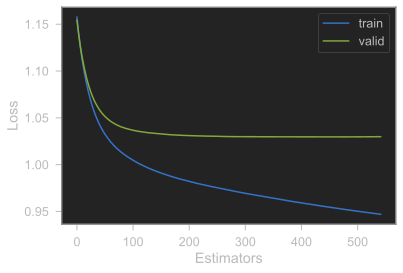

In [84]:
X_train_selected = X_train[feature_selection]
X_valid_selected = X_valid[feature_selection]

numeric_cols = X_train_selected.select_dtypes(include=[np.number]).columns
string_cols = X_train_selected.select_dtypes(exclude=[np.number]).columns

X_train_selected[string_cols] = X_train_selected[string_cols].astype("category")
X_valid_selected[string_cols] = X_valid_selected[string_cols].astype("category")

lgb_model_final = lgb.LGBMClassifier(**lgb_params)
lgb_model_final.fit(X_train_selected, y_train,
                    early_stopping_rounds=100, 
                    eval_set=[(X_train_selected, y_train), (X_valid_selected, y_valid)],
                    verbose=100)

train_score = score_model(lgb_model_final, X_train_selected, y_train)
valid_score = score_model(lgb_model_final, X_valid_selected, y_valid)
print(f'Train score: {train_score:.4}, Valid score: {valid_score:.4}')

plt.plot(lgb_model_final.evals_result_['training']['multi_logloss'], label='train')
plt.plot(lgb_model_final.evals_result_['valid_1']['multi_logloss'], label='valid')
plt.xlabel("Estimators")
plt.ylabel('Loss')
plt.legend()
plt.show()

![title](img/final_model.png)

In [134]:
lgb_model_final.booster_.save_model('lgbm.txt')

In [135]:
# lgb_model_final = lgb.Booster(model_file='lgbm.txt')

---

# 7. Prediction

In [15]:
test_users = pd.read_csv('test_users.csv')
test_users['gender'] = test_users['gender'].apply(lambda x: x.lower())
test_users.loc[test_users['language'] == 'ca', 'language'] = 'en'
test_users['timestamp_first_active'] = pd.to_datetime(test_users['timestamp_first_active'], format='%Y%m%d%H%M%S')
test_users['date_account_created'] = test_users['date_account_created'].astype('datetime64[ns]')
test_users['date_first_booking'] = test_users['date_first_booking'].astype('datetime64[ns]')
# test_users.loc[test_users['gender'] == '-unknown-', 'gender'] = np.nan

test_users.loc[test_users['age'] > 1900, 'age'] = 2015 - test_users['age']
test_users.loc[(test_users['age'] > 100) | (test_users['age'] < 15), 'age'] = np.nan

test_users['age_group'] = np.nan
test_users.loc[test_users['age'] < 4, 'age_group'] = '0-4'
test_users.loc[(test_users['age'] >= 5) & (test_users['age'] < 9), 'age_group'] = '5-9'
test_users.loc[(test_users['age'] >= 10) & (test_users['age'] < 14), 'age_group'] = '10-14'
test_users.loc[(test_users['age'] >= 15) & (test_users['age'] < 19), 'age_group'] = '15-19'
test_users.loc[(test_users['age'] >= 20) & (test_users['age'] < 24), 'age_group'] = '20-24'
test_users.loc[(test_users['age'] >= 25) & (test_users['age'] < 29), 'age_group'] = '25-29'
test_users.loc[(test_users['age'] >= 30) & (test_users['age'] < 34), 'age_group'] = '30-34'
test_users.loc[(test_users['age'] >= 35) & (test_users['age'] < 39), 'age_group'] = '35-39'
test_users.loc[(test_users['age'] >= 40) & (test_users['age'] < 44), 'age_group'] = '40-44'
test_users.loc[(test_users['age'] >= 45) & (test_users['age'] < 49), 'age_group'] = '45-49'
test_users.loc[(test_users['age'] >= 50) & (test_users['age'] < 54), 'age_group'] = '50-54'
test_users.loc[(test_users['age'] >= 55) & (test_users['age'] < 59), 'age_group'] = '55-59'
test_users.loc[(test_users['age'] >= 60) & (test_users['age'] < 64), 'age_group'] = '60-64'
test_users.loc[(test_users['age'] >= 65) & (test_users['age'] < 69), 'age_group'] = '65-69'
test_users.loc[(test_users['age'] >= 70) & (test_users['age'] < 74), 'age_group'] = '70-74'
test_users.loc[(test_users['age'] >= 75) & (test_users['age'] < 79), 'age_group'] = '75-79'
test_users.loc[(test_users['age'] >= 80) & (test_users['age'] < 84), 'age_group'] = '80-84'
test_users.loc[(test_users['age'] >= 85) & (test_users['age'] < 89), 'age_group'] = '85-89'
test_users.loc[(test_users['age'] >= 90) & (test_users['age'] < 94), 'age_group'] = '90-94'
test_users.loc[(test_users['age'] >= 95) & (test_users['age'] < 99), 'age_group'] = '95-99'
test_users.loc[test_users['age'] >= 100, 'age_group'] = '100+'

In [97]:
X_test_data = test_users.drop(columns=['id', 'date_first_booking', 'date_account_created', 'timestamp_first_active', 'age_group', 'age'])
string_cols = X_test_data.select_dtypes(exclude=[np.number]).columns
X_test_data[string_cols] = X_test_data[string_cols].astype('category')
test_users['weighted_feature'] = lgb_model_weighted.predict(X_test_data)

test_users['year_account_created'] = test_users['date_account_created'].dt.year.astype('int32')
test_users['month_account_created'] = test_users['date_account_created'].dt.month.astype('int32')
test_users['day_account_created'] = test_users['date_account_created'].dt.day.astype('int32')
test_users['weekday_account_created'] = test_users['date_account_created'].dt.weekday
test_users['year_first_active'] = test_users['timestamp_first_active'].dt.year.astype('int32')
test_users['month_first_active'] = test_users['timestamp_first_active'].dt.month.astype('int32')
test_users['day_first_active'] = test_users['timestamp_first_active'].dt.day.astype('int32')
test_users['weekday_first_active'] = test_users['timestamp_first_active'].dt.weekday

test_users = pd.merge(test_users, secs_elapsed_stats, how='left', left_on='id', right_on='user_id')

test_users['global_device'] = np.nan
test_users.loc[np.isin(test_users['first_device_type'], ['Mac Desktop', 'Windows Desktop', 'Desktop (Other)']), 'global_device'] = 'pc'
test_users.loc[np.isin(test_users['first_device_type'], ['iPhone', 'Android Tablet', 'iPad', 'Android Phone', 'SmartPhone (Other)']), 'global_device'] = 'mobile'
test_users.loc[np.isin(test_users['first_device_type'], ['Other/Unknown']), 'global_device'] = 'other'

test_users = pd.merge(test_users, age_first_browser, how='left', on='first_browser', suffixes=('', '_first_browser'))
test_users = pd.merge(test_users, age_language, how='left', on='language', suffixes=('', '_language'))
test_users = pd.merge(test_users, age_affiliate_provider, how='left', on='affiliate_provider', suffixes=('', '_affiliated_provider'))

test_users = pd.merge(test_users, total_actions_counter, how='left', left_on='id', right_on='user_id')

test_users = pd.merge(test_users, action_type_counter, how='left', left_on='id', right_on='user_id')
test_users = pd.merge(test_users, action_detail_counter, how='left', left_on='id', right_on='user_id')
test_users = pd.merge(test_users, action_counter, how='left', left_on='id', right_on='user_id')
test_users = pd.merge(test_users, device_type_counter, how='left', left_on='id', right_on='user_id')

test_users = pd.merge(test_users, language_counter, how='left', on='language')
test_users = pd.merge(test_users, first_browser_counter, how='left', on='first_browser')
test_users = pd.merge(test_users, first_device_type_counter, how='left',on='first_device_type')
test_users = pd.merge(test_users, signup_app_counter, how='left', on='signup_app')
test_users = pd.merge(test_users, first_affiliate_tracked_counter, how='left',on='first_affiliate_tracked')
test_users = pd.merge(test_users, affiliate_channel_counter, how='left', on='affiliate_channel')

test_users = pd.merge(test_users, language_age_group_counter, how='left', on=['language', 'age_group'])
test_users = pd.merge(test_users, first_brows_device_type_signup_counter, how='left', on=['first_browser', 'first_device_type', 'signup_app'])
test_users = pd.merge(test_users, first_affiliate_tracked_affiliate_channel_counter, how='left', on=['first_affiliate_tracked', 'affiliate_channel'])

test_users.shape

(62096, 685)

In [ ]:
for index in index_list:
    for value in values_list:
        aggregated_table = temporary_data.pivot_table(index=index,
                                                      columns='country_destination',
                                                      values=value,
                                                      aggfunc='median').fillna(0).add_prefix(f'{index}_{value}_')
        test_users = pd.merge(test_users, aggregated_table, how='left', on=index)
        
test_users.shape

In [59]:
# importance_scores = pd.read_csv("importance_scores.csv", index_col=0)
# feature_selection = importance_scores.loc[importance_scores['importance-mean'] > 0, 'features'].values
# lgb_model_final = lgb.Booster(model_file='lgbm.txt')
# with open('lgb_params', 'r') as f:
#     lgb_params = json.load(f)

In [99]:
X_test_selected = test_users[feature_selection]
string_cols = X_train_selected.select_dtypes(exclude=[np.number]).columns
X_test_selected[string_cols] = X_test_selected[string_cols].astype("category")
X_test_selected.shape

(62096, 185)

In [100]:
y_predict = lgb_model_final.predict_proba(X_test_selected)

In [101]:
# Forming submitting table
k = 5 # @k=5
result = pd.DataFrame(columns=['id', 'country'])
prediction_df = pd.DataFrame(data=y_predict, columns=le.inverse_transform(np.unique(y_train_data)))
for line in range(len(y_predict)):
    result = result.append(pd.DataFrame({'id': [test_users['id'].iloc[line] for _ in range(k)], 
                                         'country': prediction_df.iloc[line].nlargest(k).index,
                                        }), ignore_index=True)
result.shape

(310480, 2)

In [104]:
result.to_csv('prediction.csv', index=False, encoding='utf-8')

In [105]:
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f prediction.csv -m "Prediction_final_model"

100%|██████████████████████████████████████| 4.38M/4.38M [00:03<00:00, 1.45MB/s]
Successfully submitted to Airbnb New User Bookings

The result of private leaderboard accords to 101 stand from 1458 participants (top 7%)

![title](img/submission_result.png)